#### 분석 준비, 데이터 불러오기, 데이터 변환

In [1]:
# 분석을 위한 라이브러리
import numpy as np
import pandas as pd

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumSquareNeo/TTF')
from datetime import datetime

# 에러메세지 안나오게
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [2]:
# 데이터타입 변환 함수
def columns_datetype_change(data,columns, datetype):
    data[columns] = data[columns].astype(datetype)
    if datetype == 'datetime64':
        data[columns] = data[columns].apply(lambda x: datetime.strftime(x, '%Y-%m-%d %H:%M:%S')).astype('datetime64[ns]')

# 결측값 확인
def null_check(data):
    return (data.isnull().sum() / data.shape[0]) * 100

# 데이터 info
def data_info(data):
    display(data.head(5),data.info())

# 정수형, 실수형을 제외한 나머지 데이터타입의 유니크값
def colmuns_unique(data):
    for c in data.columns:
        if data[c].dtype not in ['int64', 'float64']:
            print(f'------------{c}------------')
            print(data[f'{c}'].unique())
            
def memory_small(data):
    for c in data.columns:
        if data[c].dtype == 'int64':
            data[c] = data[c].astype('int32')
        elif data[c].dtype == 'object' and data[c].nunique()<10:
            data[c] = data[c].astype('category')

In [3]:
# 데이터불러오기
tranfinal_cus =  pd.read_csv('data_file/tranfinal_cus.csv')
click_stream_new =  pd.read_csv('data_file/click_stream_new.csv')
product =  pd.read_csv('data_file/product.csv',on_bad_lines='skip')
new =  pd.read_csv('data_file/transaction_new.csv')

In [4]:
# 데이터 변환
columns_datetype_change(tranfinal_cus,'first_join_date','datetime64')
columns_datetype_change(tranfinal_cus,'birthdate','datetime64')

# 가입날짜 년,월,일 컬럼 따로 생성.
tranfinal_cus['join_date'] = tranfinal_cus['first_join_date'].dt.strftime('%Y-%m')
tranfinal_cus['join_month'] = tranfinal_cus['first_join_date'].dt.strftime('%m')
tranfinal_cus['join_day'] = tranfinal_cus['first_join_date'].dt.strftime('%d')
tranfinal_cus['join_year'] = tranfinal_cus['first_join_date'].dt.strftime('%Y')

# 불필요한 컬럼 삭제.
tranfinal_cus.drop(columns=['first_name','last_name','username','email','device_id','device_version','home_country','home_location_lat','home_location_long','home_location'],axis=1,inplace=True)

# 주문날짜 년,일 컬럼 따로 생성
tranfinal_cus['created_at_3'] = pd.to_datetime(tranfinal_cus['created_at']).dt.strftime('%Y-%m-%d').astype('datetime64')
tranfinal_cus['created_at_5'] = pd.to_datetime(tranfinal_cus['created_at']).dt.strftime('%Y')

# 첫 구매까지의 기간 컬럼 생성.
tranfinal_cus['가입 후 첫구매까지의 기간'] = (pd.to_datetime(tranfinal_cus['created_at']) - tranfinal_cus['first_join_date']).dt.days.fillna(-1)

# 나이 컬럼 생성.
from datetime import datetime
current_date = datetime.now().date()
tranfinal_cus['age'] = (current_date - tranfinal_cus['birthdate'].dt.date).dt.days // 365
tranfinal_cus['age2'] = tranfinal_cus['age'].apply(lambda x : (x // 10) *10)

#### 데이터 생성

- transaction_new 데이터의 경우 구매한 제품이 각 행에 입력되어있고, 총합또한 각 행에 입력되어 데이터 구조를 변경함.

In [ ]:
new['shipment_period'] = new.shipment_date_limit-new.created_at

new.drop(columns=['shipment_location_lat','shipment_location_long'],axis=1,inplace=True)

new.loc[new['promo_code'].isnull(),'promo_code']='Nopromo'

In [ ]:
transaction1 = new.groupby(['created_at','customer_id']).agg({'promo_amount':'max','shipment_fee':'max', 'total_amount':'max',
                                                                          'quantity':'sum','shipment_period':'max'}).sort_index(ascending=True).reset_index()
transaction2 = new[['created_at','customer_id','booking_id','session_id','total_amount', 'promo_code', 'payment_method', 'payment_status']].drop_duplicates()

In [ ]:
transaction_final = pd.merge(transaction1,transaction2, on=['created_at','customer_id','total_amount'], how='left')
transaction_final['promo_yesno'] = transaction_final.promo_code.apply(lambda x:'x' if x=='Nopromo' else 'o')
transaction_final['created_at_2'] = transaction_final['created_at'].apply(lambda x: datetime.strftime(x, '%Y-%m'))

#### 프로모션

In [ ]:
# 프로모션 적용여부에 따른 비율
plt.figure(figsize=(5,5),facecolor='white')
colors = ['#B6E2A1','silver']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
tranfinal_cus.promo_yesno.value_counts(normalize=True).plot.pie(textprops={'size':17},colors=colors,wedgeprops=wedgeprops,autopct='%.1f%%',counterclock=False,startangle=45)
plt.title('Enable/Disable Promotion',fontsize=20,fontweight='bold',y=1.1)
plt.ylabel('')
plt.legend(['o:Enable promotion','x:Disable Promotion'],loc=[0.8,0]);

In [ ]:
# 날짜별 프로모션 적용여부에 따른 매출
import matplotlib.gridspec as gridspec

plt.figure(figsize=(15, 6))

# GridSpec을 사용하여 그래프와 실눈을 함께 그리기
gs = gridspec.GridSpec(2, 1, height_ratios=[0.9, 0.1])
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax)

tmp = tranfinal_cus[tranfinal_cus.payment_status=='Success']
tran_success_g = tmp.groupby(['created_at_2', 'promo_yesno'])['total_amount'].sum().reset_index()
sns.lineplot(data=tran_success_g, x='created_at_2', y='total_amount', hue='promo_yesno', ax=ax)

# x축 레이블 변경
xticklabels = tran_success_g['created_at_2'].unique()
x_values = [label if label.endswith('-06') else '' for label in xticklabels]
plt.xticks(range(len(xticklabels)), x_values, ha='right')
ax.set_xlabel('Year-Month')

# y축 값 포맷 변경
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_ylabel('Total Amount')

# 6월에 해당하는 부분에 선 추가
for i, label in enumerate(xticklabels):
    if label.endswith('-06'):
        ax.axvline(i, color='red', linestyle='--')

# 실눈 설정
ax2.grid(True, axis='x')

# 범례 수정
ax.legend(['Promotion does not apply', 'Apply promotion'], loc='upper left')

plt.show()

In [ ]:
# 프로모션의 주말과 평일
import datetime
tmp = tranfinal_cus.groupby(['created_at','promo_code']).size().reset_index()
tmp['created_at'] = pd.to_datetime(tmp['created_at'])
tmp['date'] = (tmp['created_at'].dt.date).astype('datetime64')
tmp['time'] = tmp['created_at'].dt.time
tmp['week'] =  tmp['date'].dt.strftime('%A')
tmp

In [ ]:
tmp[tmp.promo_code!='Nopromo'].groupby(['week','promo_code']).size().reset_index()

In [ ]:
tranfinal_cus[tranfinal_cus.promo_code!='Nopromo'].groupby(['week','promo_code']).size().reset_index()

In [ ]:
# 프로모션별로 적용되는 상품이 있는지?
tran_product = pd.merge(new, product, left_on='product_id',right_on='id',how='left')
tran_product.drop(columns=['id','shipment_location_lat','shipment_location_long'],axis=1,inplace=True)
tran_product['created_at'] = pd.to_datetime(tran_product['created_at'])
tran_product['date'] = (tran_product['created_at'].dt.date).astype('datetime64')
tran_product['time'] = tran_product['created_at'].dt.time
tran_product['week'] =  tran_product['date'].dt.strftime('%A')
tran_product[~tran_product.promo_code.isnull()]['customer_id'].unique() # 프로모션을 한번이라도 사용했던 사람들
tran_product[tran_product.promo_code.isnull()]['customer_id'].unique() # 프로모션을 사용하지않은 사람들

prom_N = set(tran_product[tran_product.promo_code.isnull()]['customer_id'].unique()) - set(tran_product[~tran_product.promo_code.isnull()]['customer_id'].unique())
len(prom_N)

In [ ]:
tran_product.groupby(['promo_code','masterCategory']).count()['session_id'].reset_index()

TypeError: Invalid comparison between dtype=datetime64[ns] and str

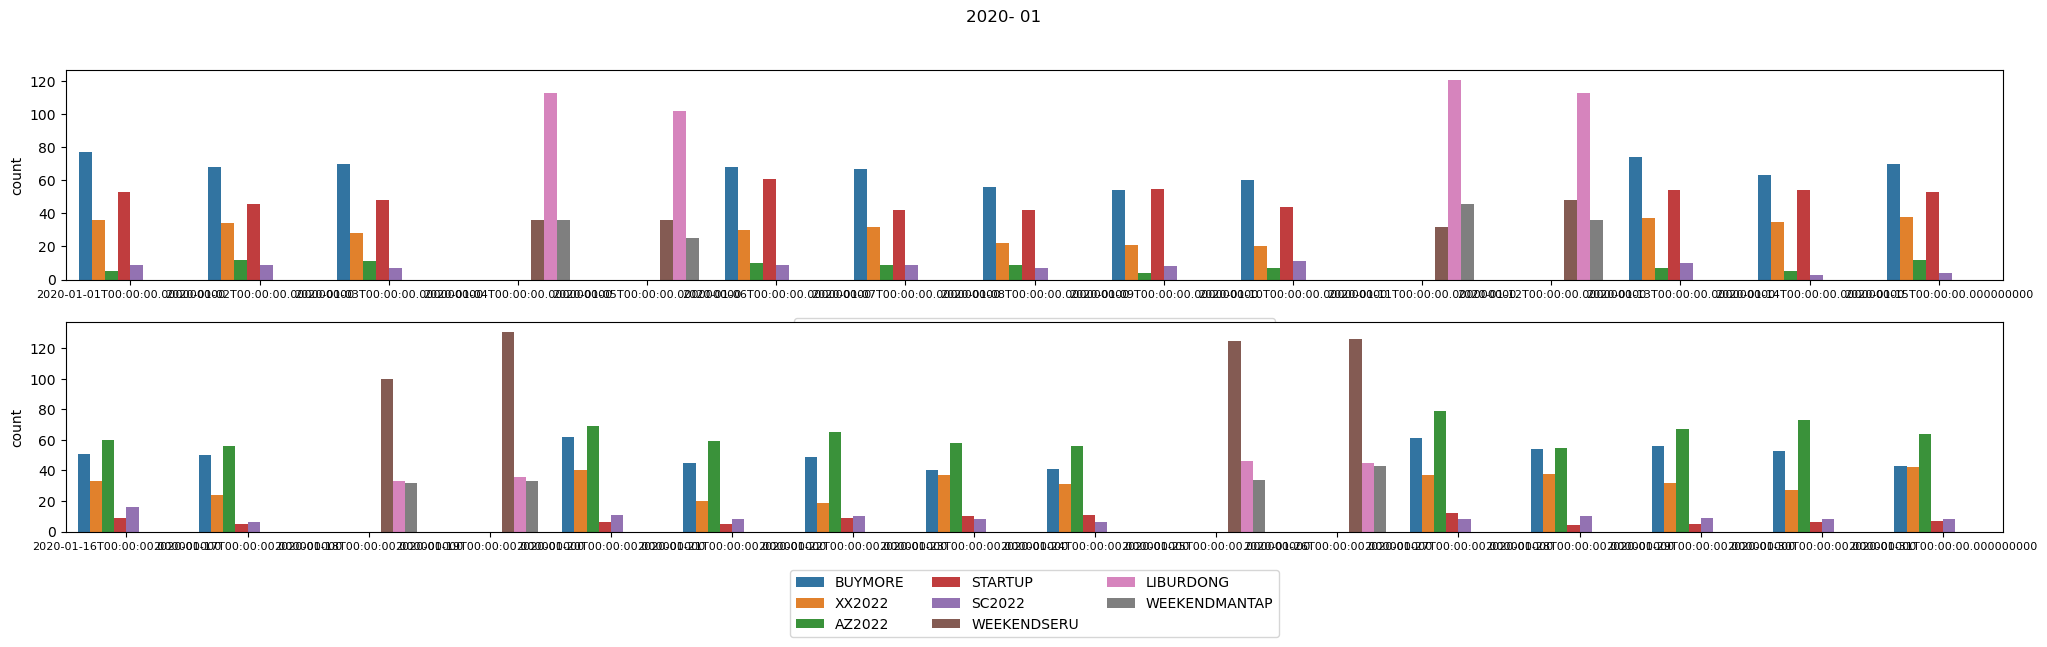

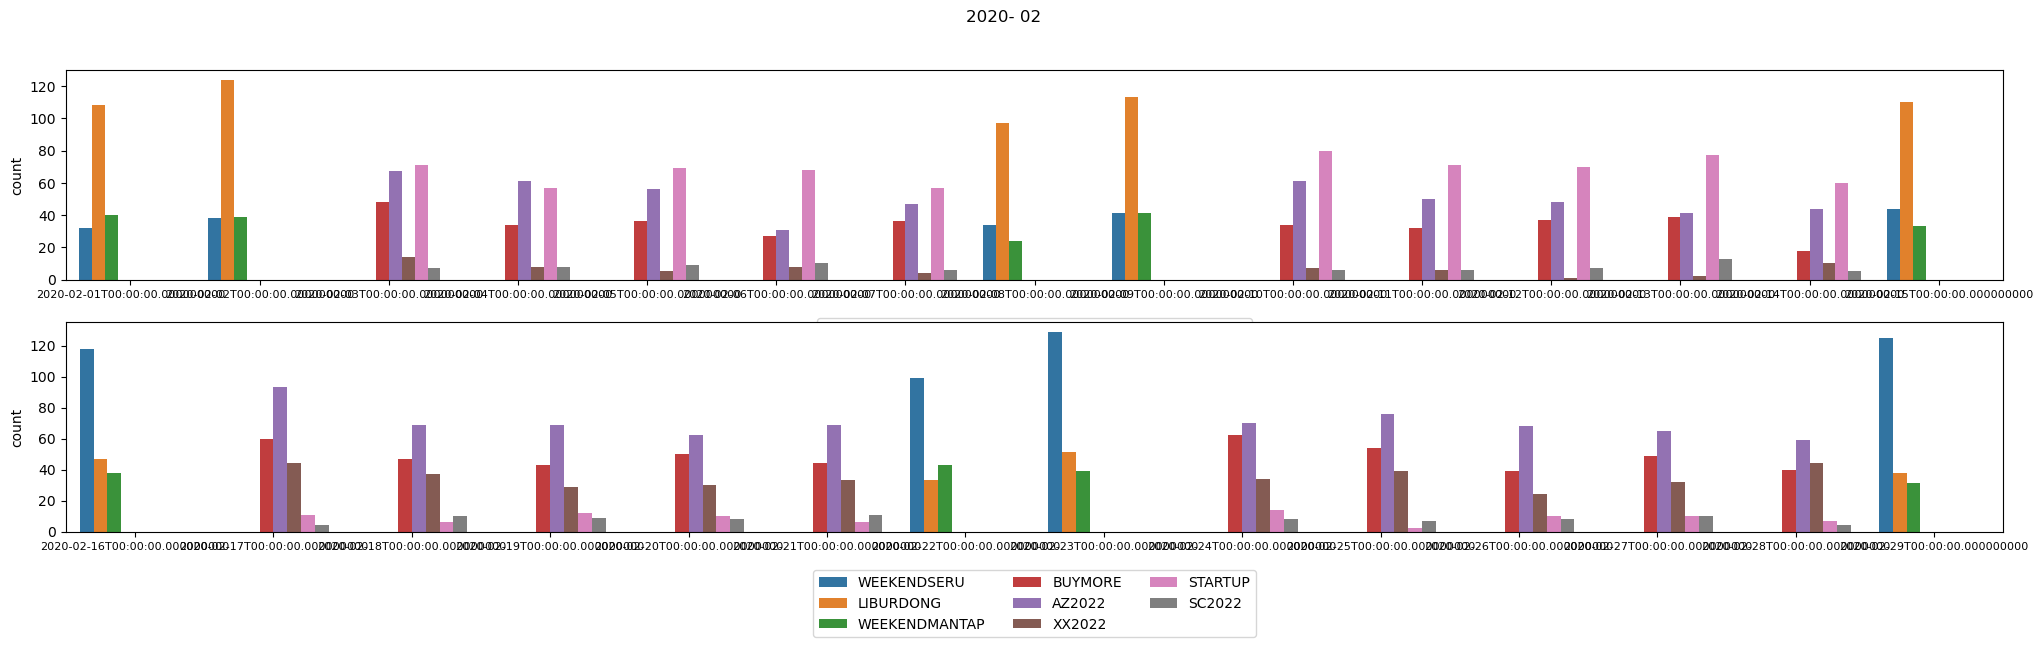

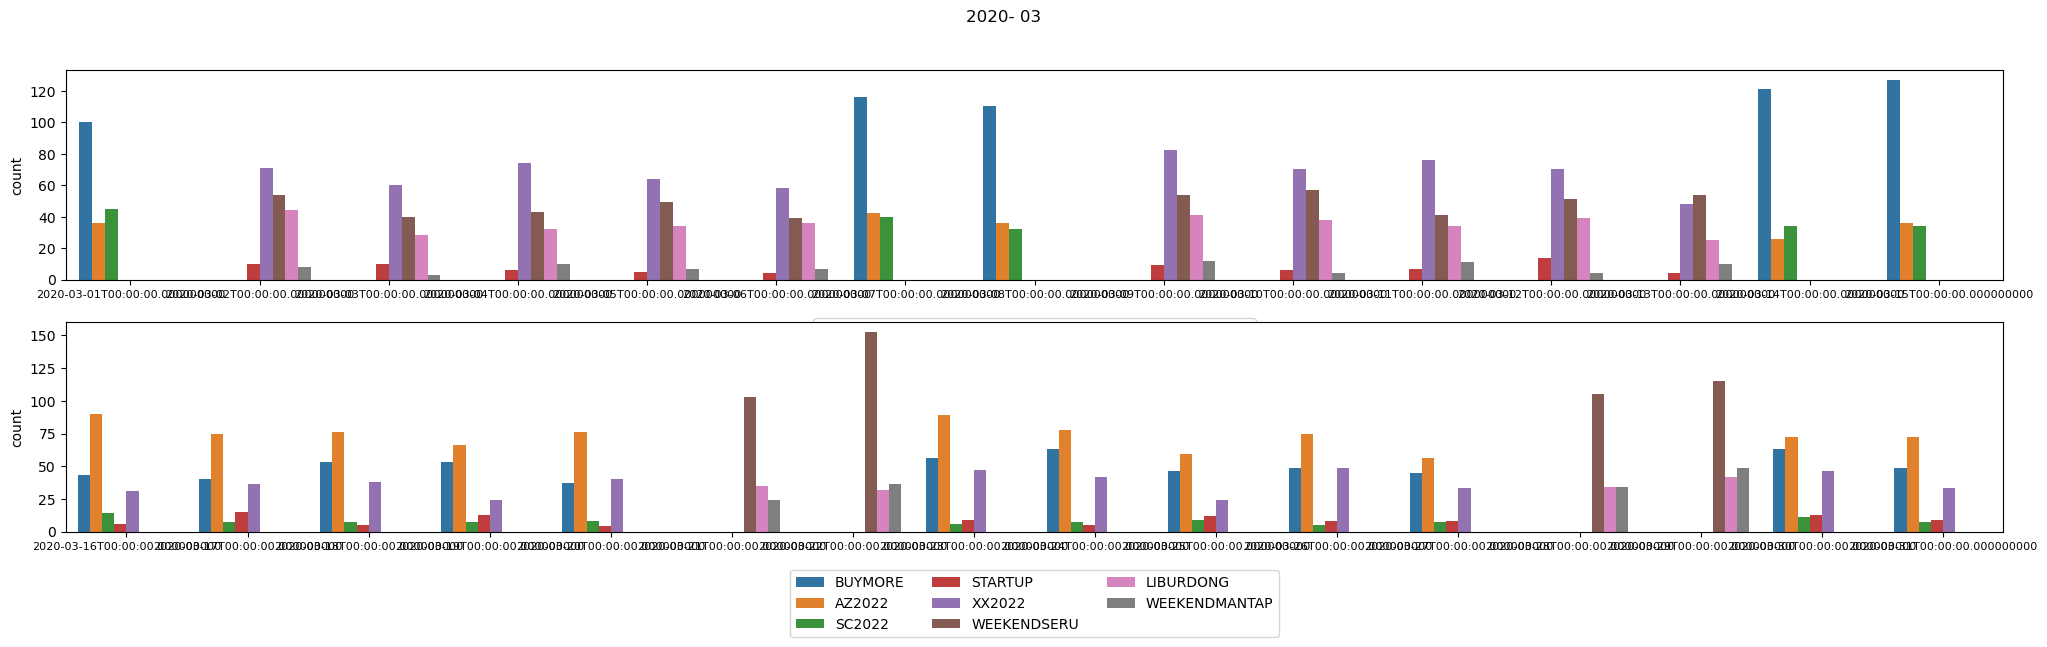

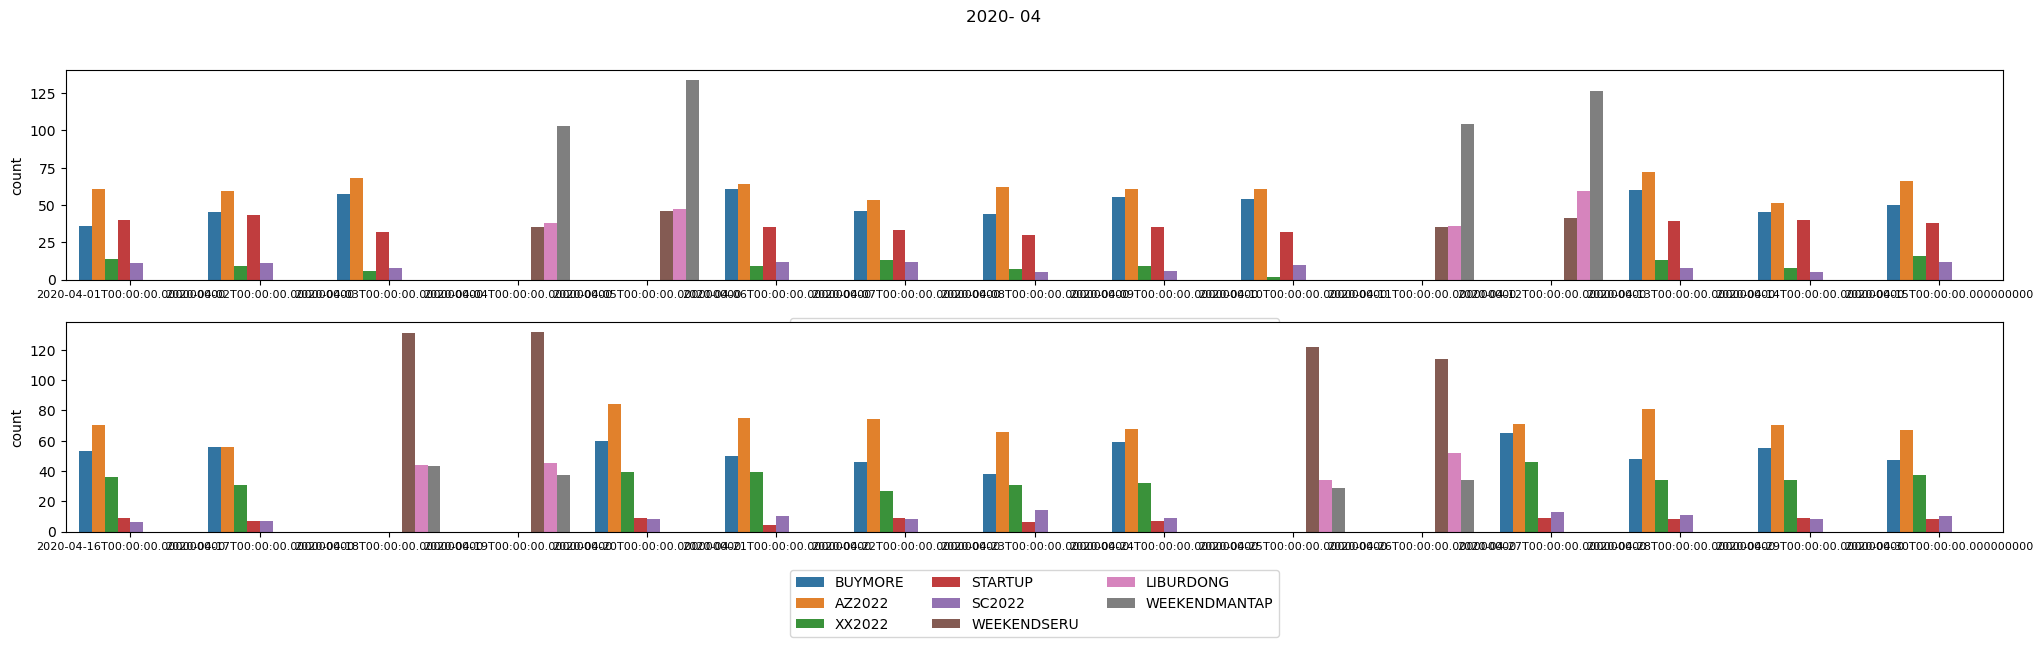

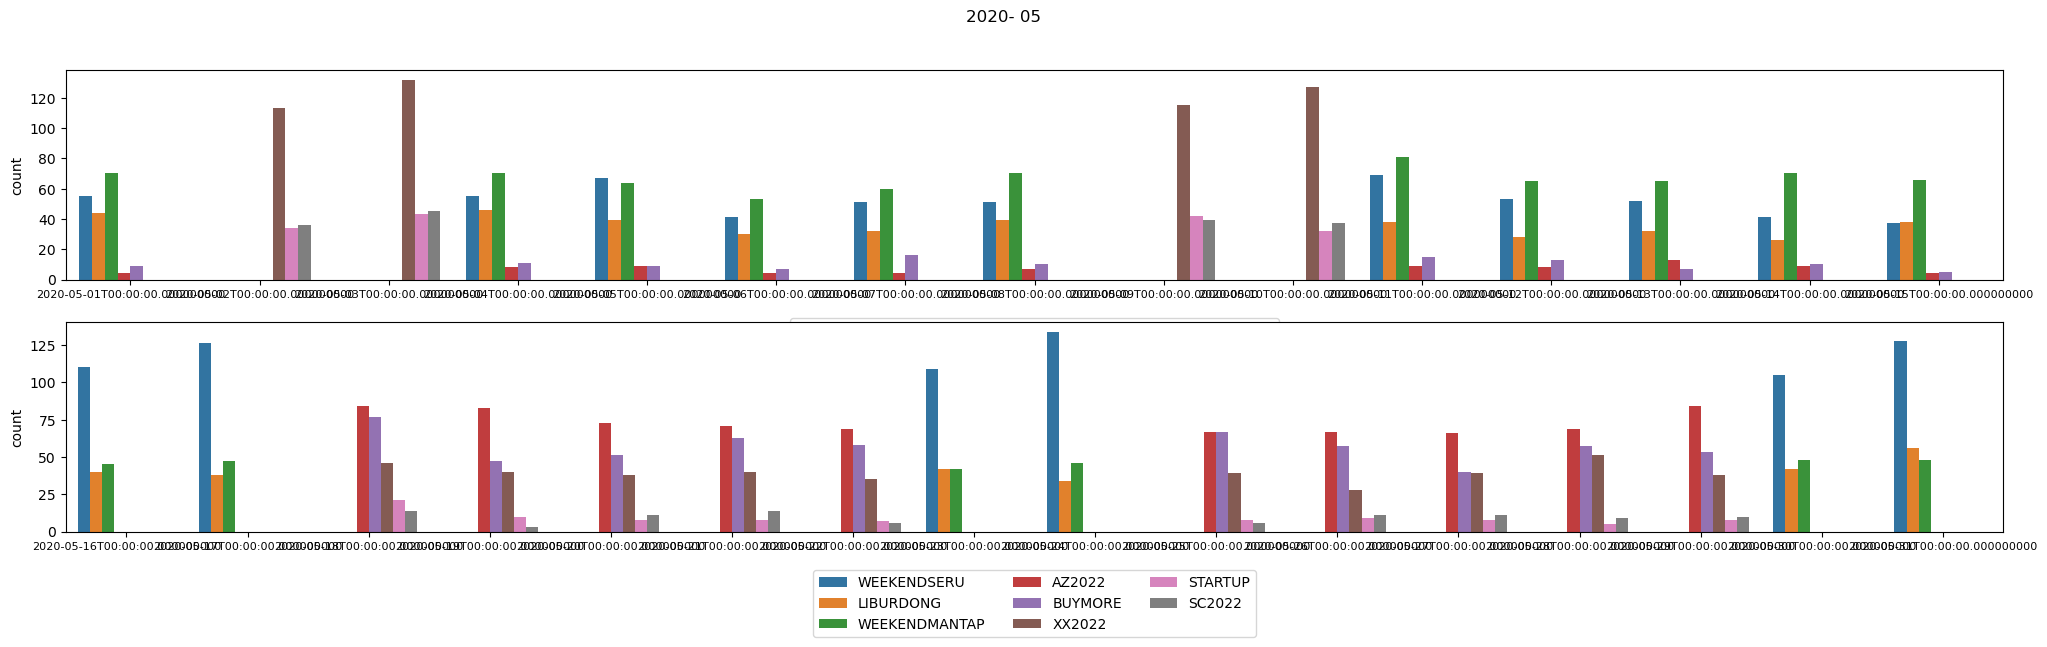

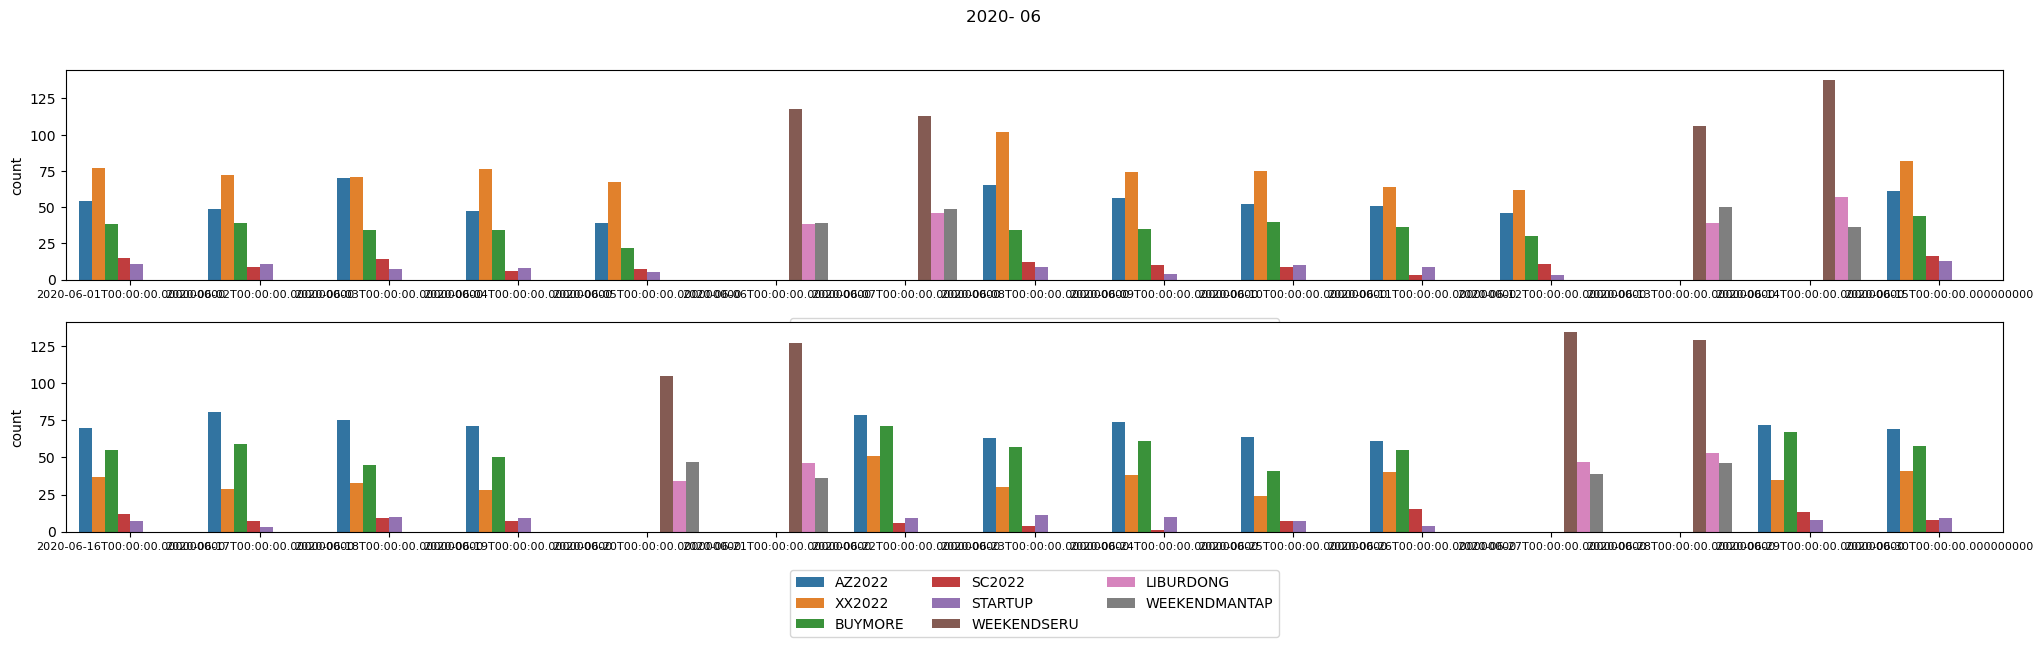

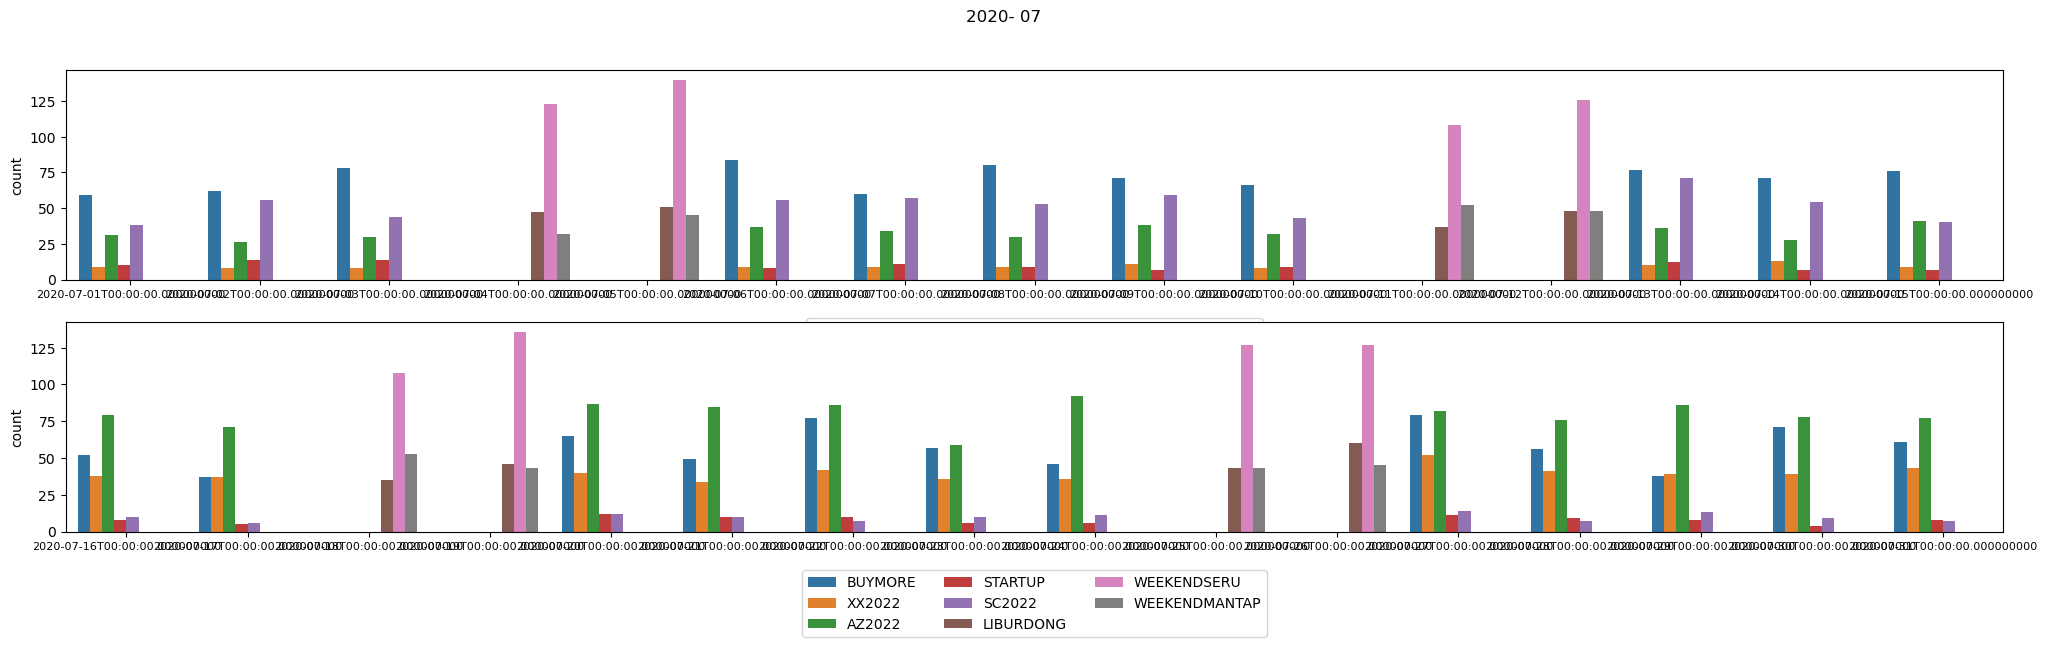

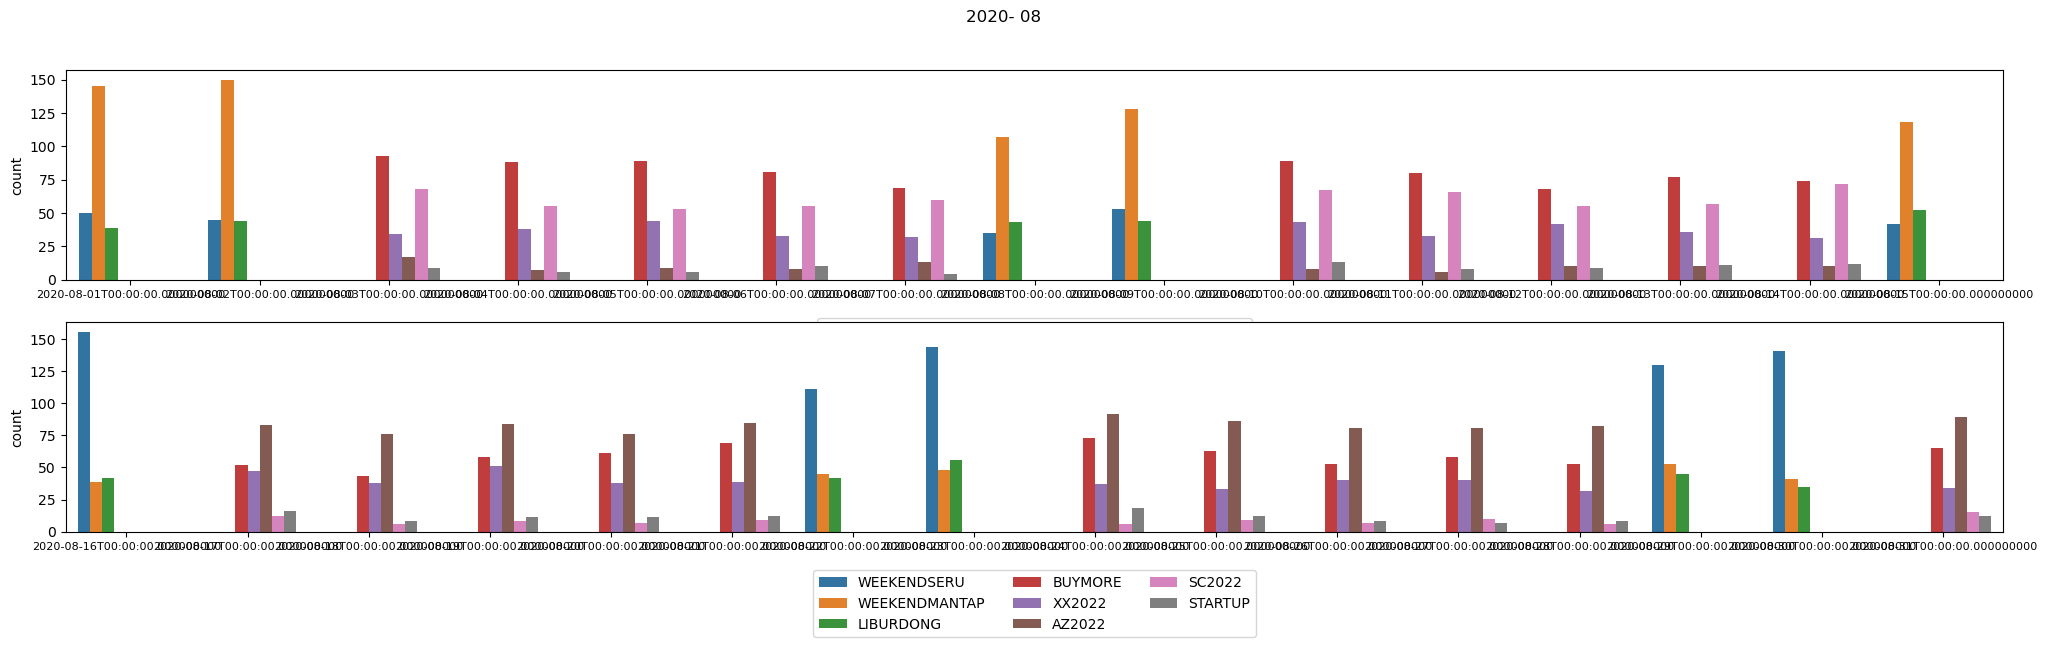

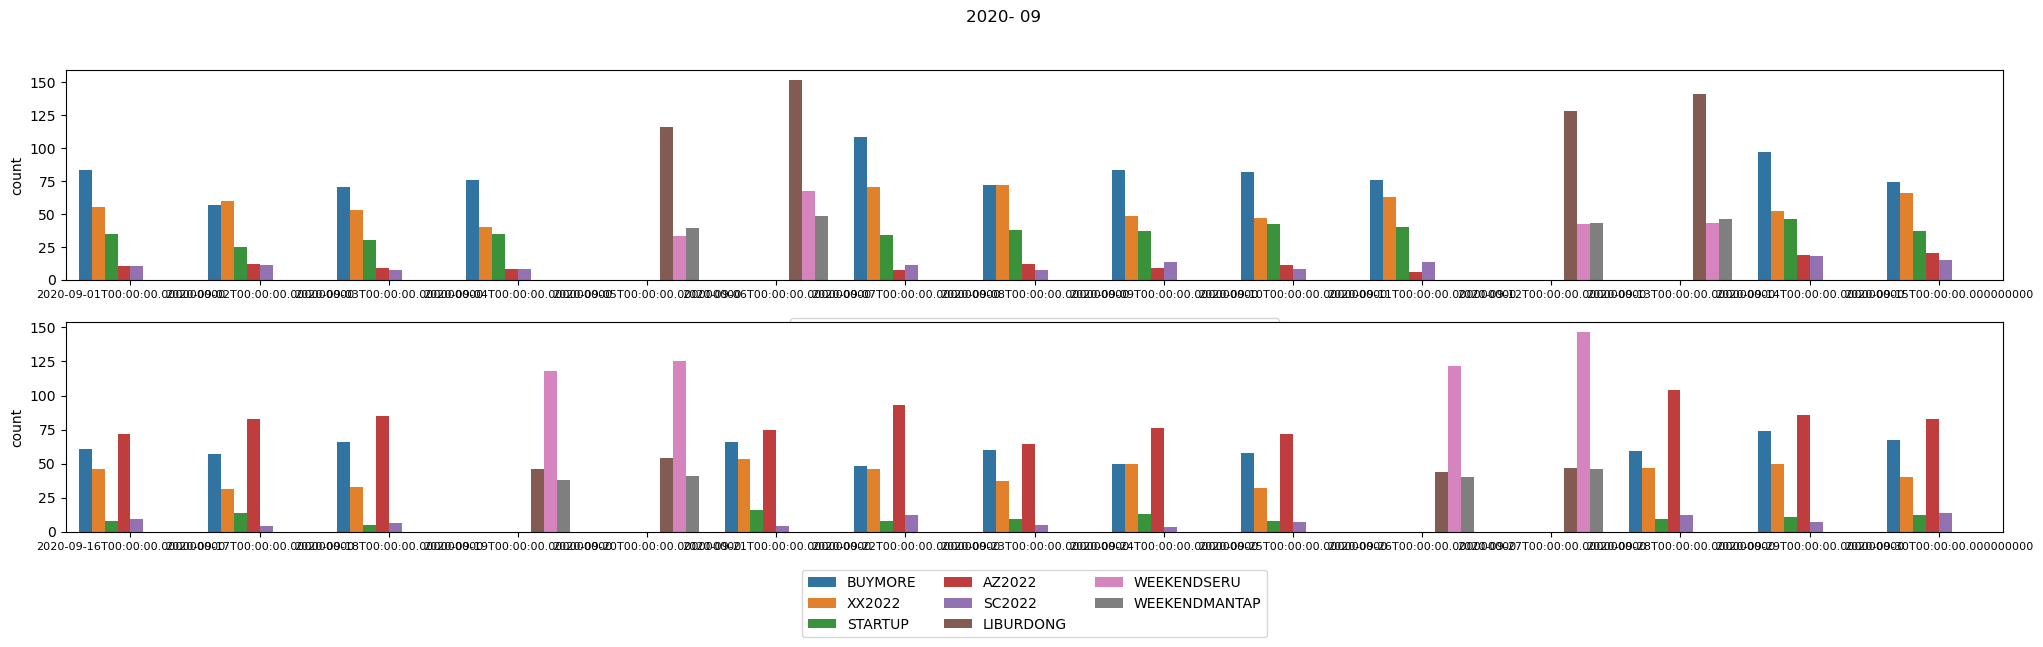

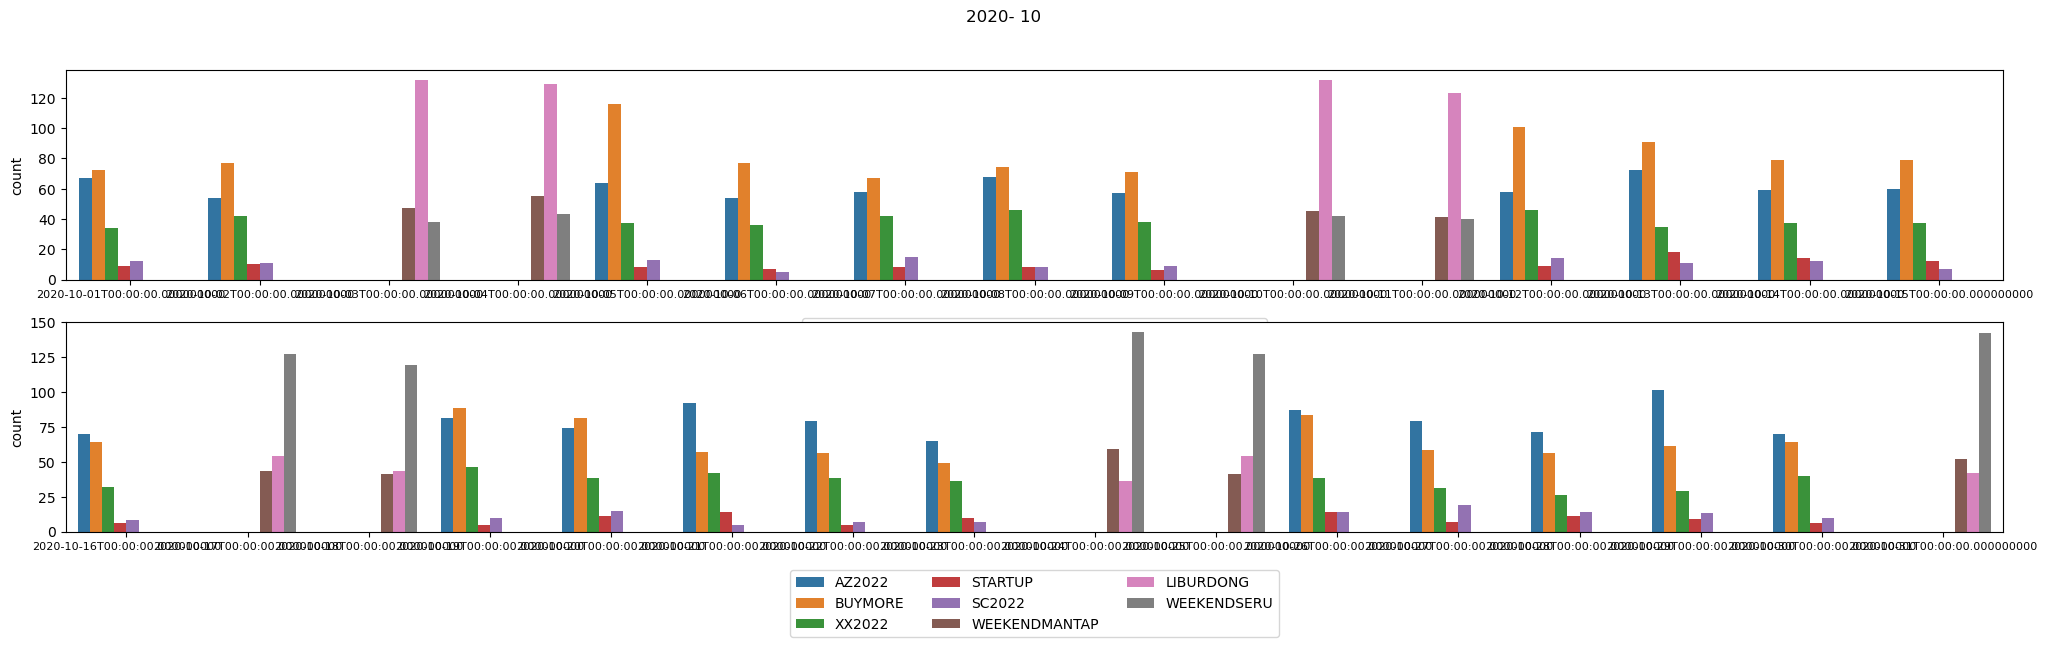

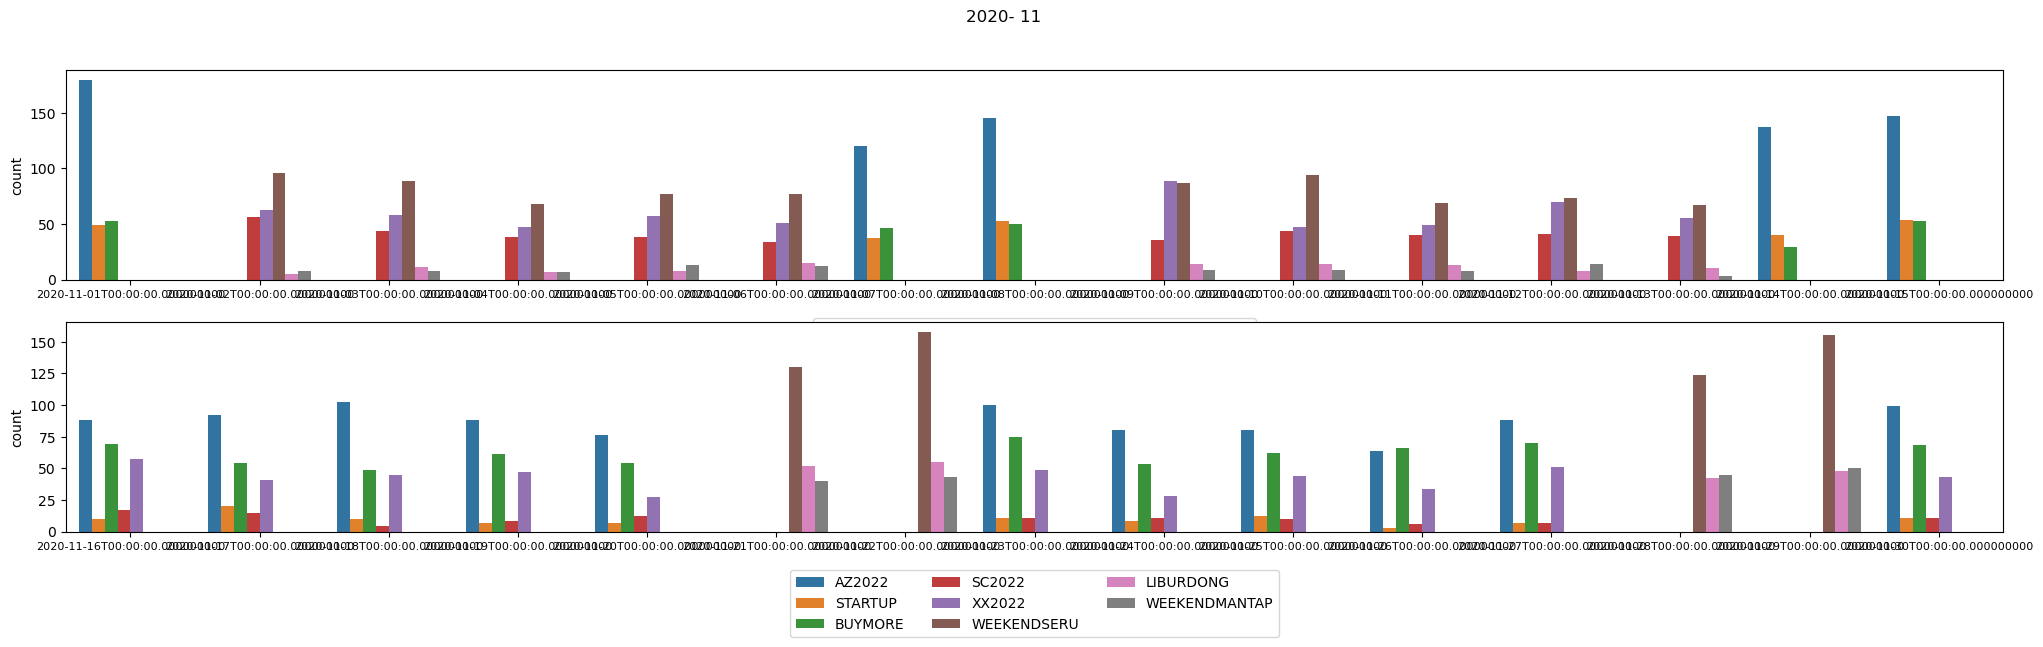

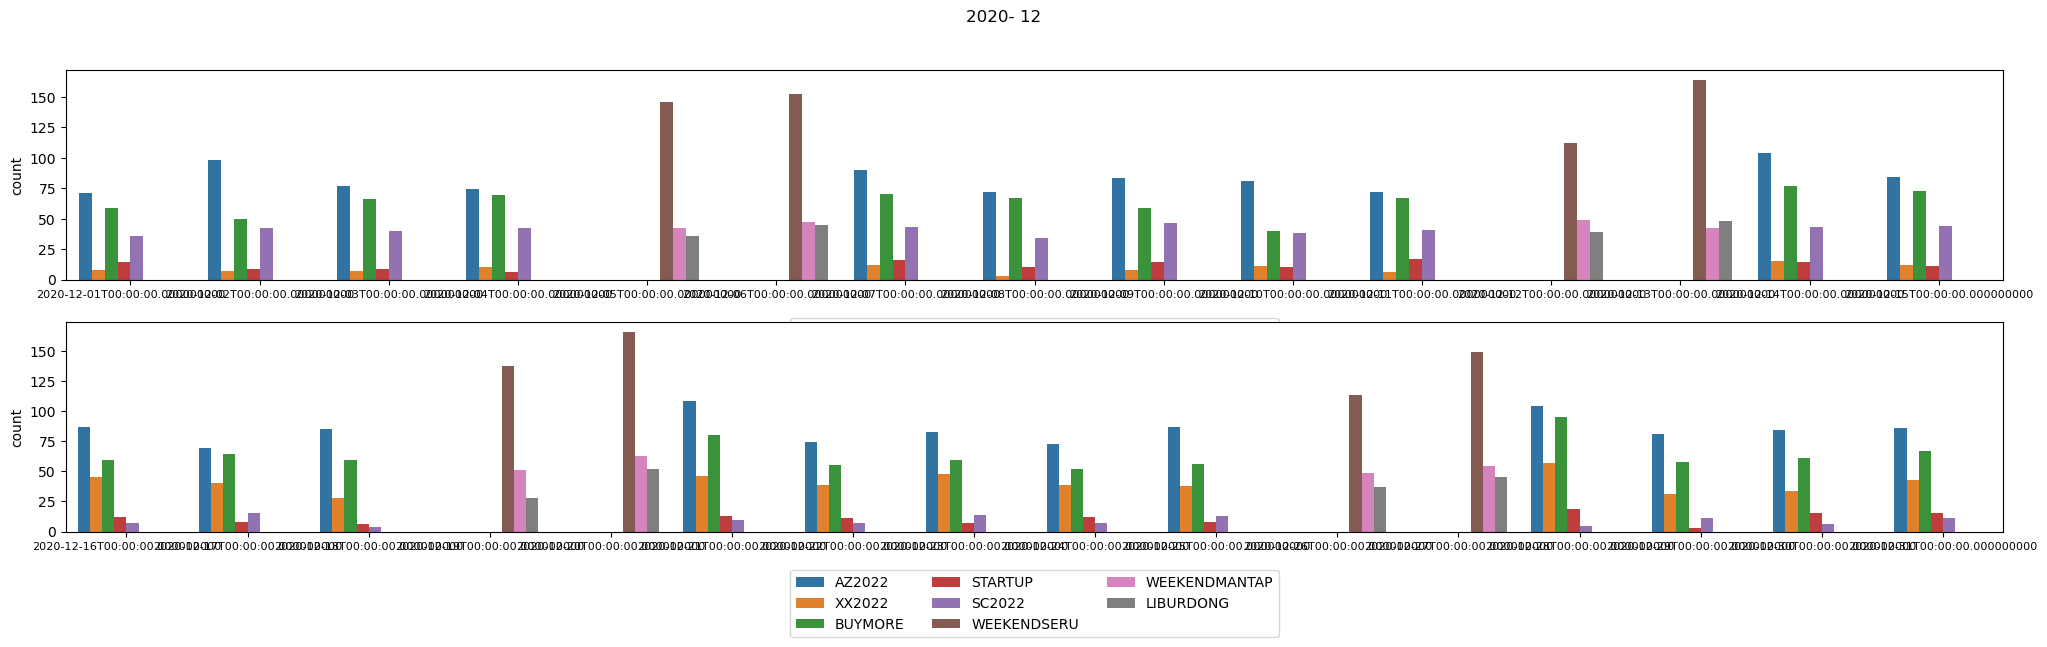

In [ ]:
import matplotlib.dates as mdates
# 연도별 프로모션 사용량 2020년도 프로모션 사용 주기
lis = [str(i).zfill(2) for i in range(1, 32)] 

for i in lis:
    code = total[(total.created_at_2==f'2020-{i}')&(total.created_at_3 <= f'2020-{i}-15')].groupby(['created_at_3','customer_id'])['promo_code'].first().reset_index()[['created_at_3','promo_code']]
    code2 = total[(total.created_at_2==f'2020-{i}')&(total.created_at_3 > f'2020-{i}-15')].groupby(['created_at_3','customer_id'])['promo_code'].first().reset_index()[['created_at_3','promo_code']]
    fig, ax = plt.subplots(2,1,figsize=(25, 6))
    plt.suptitle(f'2020- {i}')  # 제목 변경
    sns.countplot(data=code, x='created_at_3', hue='promo_code', ax=ax[0])
    sns.countplot(data=code2, x='created_at_3', hue='promo_code', ax=ax[1])
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax[0].xaxis.set_tick_params(labelsize=8)  # X축 날짜 회전 및 크기 조정
    ax[1].xaxis.set_tick_params(labelsize=8)  # X축 날짜 회전 및 크기 조정
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')

In [ ]:
import matplotlib.dates as mdates
# 연도별 프로모션 사용량 2021년도 프로모션 사용 주기
lis = [str(i).zfill(2) for i in range(1, 32)] 

for i in lis:
    code = total[(total.created_at_2==f'2021-{i}')&(total.created_at_3 <= f'2021-{i}-15')].groupby(['created_at_3','customer_id'])['promo_code'].first().reset_index()[['created_at_3','promo_code']]
    code2 = total[(total.created_at_2==f'2021-{i}')&(total.created_at_3 > f'2021-{i}-15')].groupby(['created_at_3','customer_id'])['promo_code'].first().reset_index()[['created_at_3','promo_code']]
    fig, ax = plt.subplots(2,1,figsize=(25, 6))
    plt.suptitle(f'2021- {i}')  # 제목 변경
    sns.countplot(data=code, x='created_at_3', hue='promo_code', ax=ax[0])
    sns.countplot(data=code2, x='created_at_3', hue='promo_code', ax=ax[1])
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax[0].xaxis.set_tick_params(labelsize=8)  # X축 날짜 회전 및 크기 조정
    ax[1].xaxis.set_tick_params(labelsize=8)  # X축 날짜 회전 및 크기 조정
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')

In [ ]:
import matplotlib.dates as mdates
# 연도별 프로모션 사용량 2022년도 프로모션 사용 주기
lis = [str(i).zfill(2) for i in range(1, 8)] 

for i in lis:
    code = total[(total.created_at_2==f'2022-{i}')&(total.created_at_3 <= f'2022-{i}-15')].groupby(['created_at_3','customer_id'])['promo_code'].first().reset_index()[['created_at_3','promo_code']]
    code2 = total[(total.created_at_2==f'2022-{i}')&(total.created_at_3 > f'2022-{i}-15')].groupby(['created_at_3','customer_id'])['promo_code'].first().reset_index()[['created_at_3','promo_code']]
    fig, ax = plt.subplots(2,1,figsize=(25, 6))
    plt.suptitle(f'2022- {i}')  # 제목 변경
    sns.countplot(data=code, x='created_at_3', hue='promo_code', ax=ax[0])
    sns.countplot(data=code2, x='created_at_3', hue='promo_code', ax=ax[1])
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax[0].xaxis.set_tick_params(labelsize=8)  # X축 날짜 회전 및 크기 조정
    ax[1].xaxis.set_tick_params(labelsize=8)  # X축 날짜 회전 및 크기 조정
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')

#### 비활성고객

In [6]:
# (5년기준)비활성고객비율, 재구매율

# 회원 전체수
total_customer = tranfinal_cus.groupby('customer_id')['session_id'].count().reset_index()

# 1회이상 구매했던 고객
tran_sucess = tranfinal_cus[tranfinal_cus['payment_status']=='Success'].groupby('customer_id')['session_id'].count().reset_index() # 1회이상 구매했던 고객

# 한번도 구매하지 않은 고객
tran_no = total_customer.shape[0] - tran_sucess.shape[0]

# 전체기간의 비활성 고객 비율
print('⭐전체기간 0회구매 비율(비활성 고객 비율) : ',round(tran_no / total_customer.shape[0] * 100,2))
# 전체 기간의 재구매율
tran_rebuy2 = tran_sucess[tran_sucess.session_id >= 1]
tran_rebuy3 = tran_rebuy2[tran_rebuy2.session_id > 1]
print('⭐전체기간 재구매율(1회 구매한 고객 중 재구매한 고객수/1번이라도 구매한 고객수) : ',round(tran_rebuy3.shape[0]/tran_rebuy2.shape[0]*100,2))


⭐전체기간 0회구매 비율(비활성 고객 비율) :  49.76
⭐전체기간 재구매율(1회 구매한 고객 중 재구매한 고객수/1번이라도 구매한 고객수) :  79.57


findfont: Font family ['NanumSquareNeo/TTF'] not found. Falling back to DejaVu Sans.


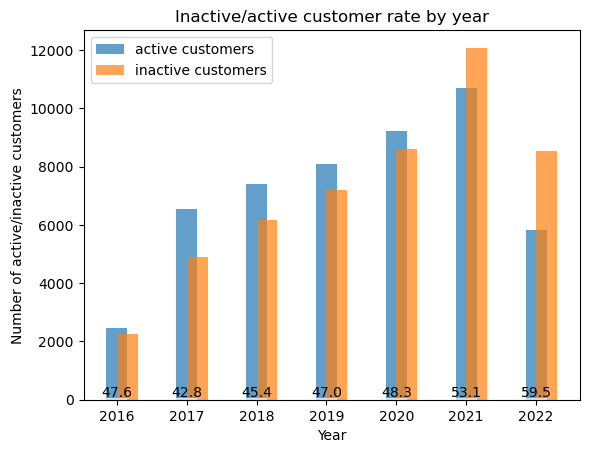

In [6]:
# (5년 기준)연도별 비활성고객율 
num_a=[]
num_b=[]
p=[]
years=range(2016,2023,1)
for i in range(2016,2023,1):
    a=tranfinal_cus[(tranfinal_cus.first_join_date.dt.year==i)&(tranfinal_cus.payment_status=='Success')].groupby('customer_id').count().shape[0]
    b=(tranfinal_cus[(tranfinal_cus.first_join_date.dt.year==i)].groupby('customer_id').count().shape[0])-a

    num_a.append(a)
    num_b.append(b)
    p.append(round(b/(a+b)*100,1))
    # print(f'-----------{i}년도----------')
    # print('비활성화고객수:',b)
    # print('활성화고객수:',a)
    # print('비활성고객율 ⭐',round(b/(a+b)*100,1),'%')

plt.bar(years,num_a, width=0.3, align='center', alpha=0.7)
plt.bar(years,num_b,width=0.3, align='edge', alpha=0.7)
plt.bar(years,p,width=0.3, align='center', alpha=0.7,color='white')
plt.xlabel('Year')
plt.ylabel('Number of active/inactive customers')
plt.title('Inactive/active customer rate by year')
for i, j in zip(years, p):
    plt.text(i, 12, str(j), ha='center', va='bottom')


plt.legend(['active customers','inactive customers']);

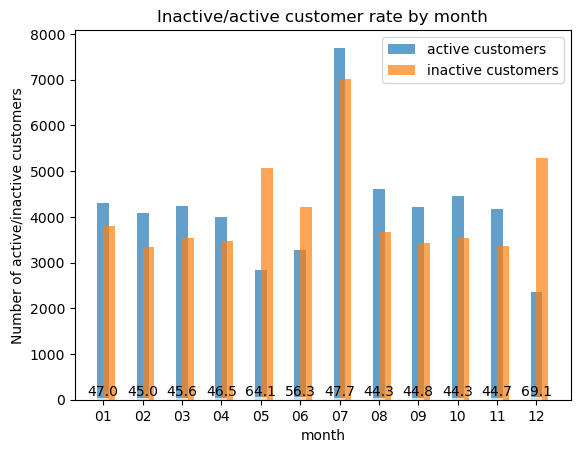

In [8]:
# (5년기준) 월별 비활성고객율
num_a=[]
num_b=[]
p=[]
month=list(['01','02','03','04','05','06','07','08','09','10','11','12'])
for i in month:
    a=tranfinal_cus[(tranfinal_cus.join_month==i)&(tranfinal_cus.payment_status=='Success')].groupby('customer_id').count().shape[0]
    b=(tranfinal_cus[(tranfinal_cus.join_month==i)].groupby('customer_id').count().shape[0])-a

    num_a.append(a)
    num_b.append(b)
    p.append(round(b/(a+b)*100,1))
    # print(f'-----------{i}월----------')
    # print('비활성화고객수:',b)
    # print('활성화고객수:',a)
    # print('비활성고객율 ⭐',round(b/(a+b)*100,1),'%')

plt.bar(month,num_a, width=0.3, align='center', alpha=0.7)
plt.bar(month,num_b,width=0.3, align='edge', alpha=0.7)
plt.bar(month,p,width=0.3, align='center', alpha=0.7,color='white')
plt.xlabel('month')
plt.ylabel('Number of active/inactive customers')
plt.title('Inactive/active customer rate by month')
for i, j in zip(month, p):
    plt.text(i, 10, str(j), ha='center', va='bottom')


plt.legend(['active customers','inactive customers']);

findfont: Font family ['NanumSquareNeo/TTF'] not found. Falling back to DejaVu Sans.


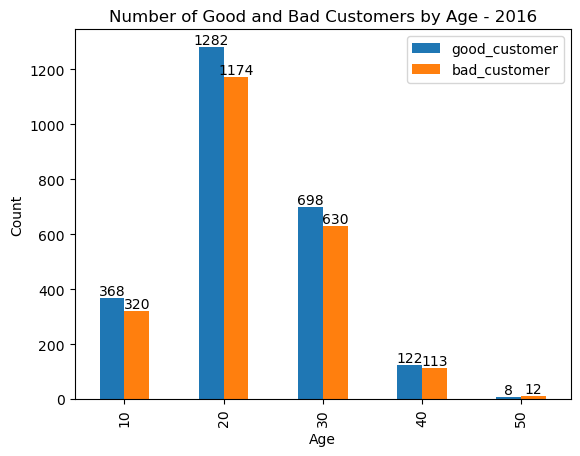

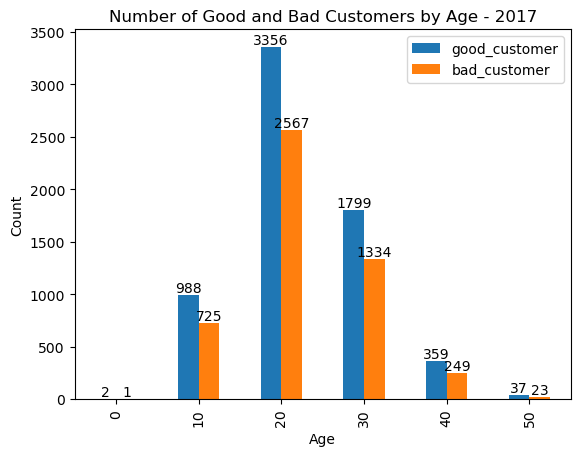

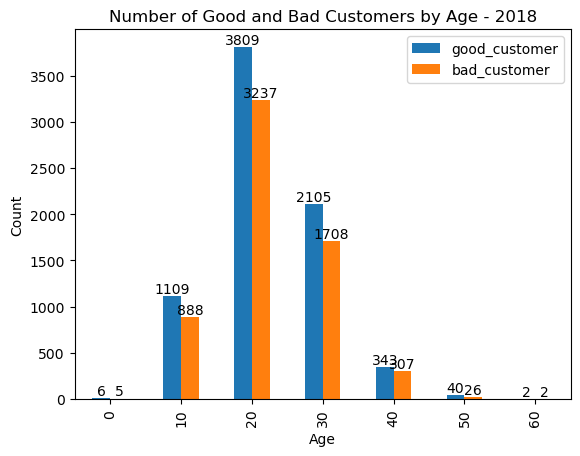

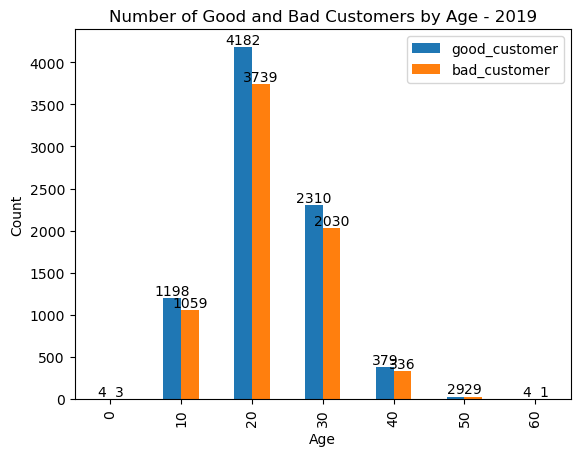

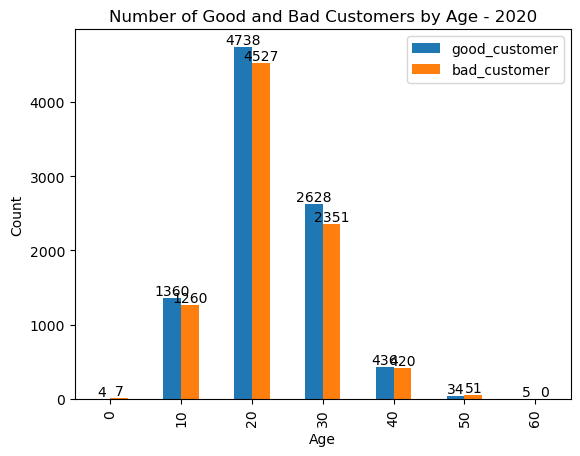

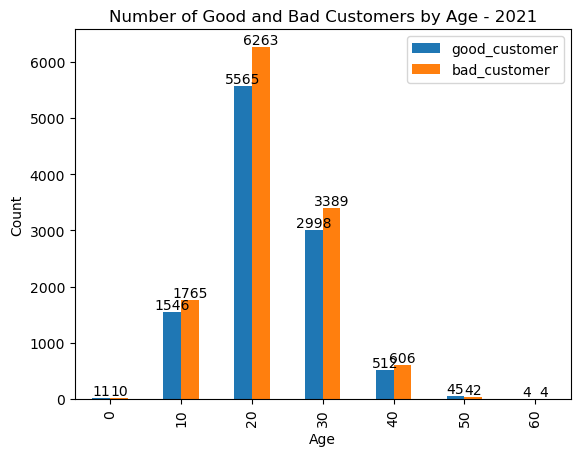

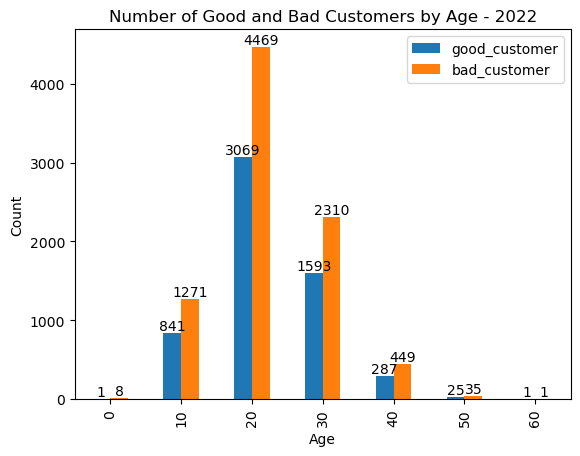

In [42]:
# 연도별 나이대별 비활성고객수파악
for i in range(2016,2023):
    a = tranfinal_cus[(tranfinal_cus.join_year == str(i)) & (tranfinal_cus.payment_status == 'Success')].groupby(['customer_id'])['age2'].first().reset_index()
    aa = a.groupby('age2').count().reset_index()

    b = tranfinal_cus[(tranfinal_cus.join_year == str(i))].groupby('customer_id')['age2'].first().reset_index()
    bb = b.groupby('age2').count().reset_index()

    a_b = pd.merge(aa, bb, on=['age2'])
    a_b.columns = ['age', 'good_customer', 'total_age']
    a_b['bad_customer'] = a_b['total_age'] - a_b['good_customer']
    a_b.drop(columns=['total_age'], axis=1, inplace=True)
    a_b.set_index('age', inplace=True)

    # 그래프 그리기
    ax = a_b.plot(kind='bar')

    # 글씨 추가
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    # 축과 제목 설정
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title(f'Number of Good and Bad Customers by Age - {i}')


-----------1월----------
비활성화고객수: 1751
활성화고객수: 1772
비활성고객율 ⭐ 49.7 %
-----------2월----------
비활성화고객수: 1907
활성화고객수: 1911
비활성고객율 ⭐ 49.9 %
-----------3월----------
비활성화고객수: 1858
활성화고객수: 1865
비활성고객율 ⭐ 49.9 %
-----------4월----------
비활성화고객수: 1736
활성화고객수: 1910
비활성고객율 ⭐ 47.6 %
-----------5월----------
비활성화고객수: 1839
활성화고객수: 1975
비활성고객율 ⭐ 48.2 %
-----------6월----------
비활성화고객수: 1662
활성화고객수: 1740
비활성고객율 ⭐ 48.9 %
-----------7월----------
비활성화고객수: 1511
활성화고객수: 1559
비활성고객율 ⭐ 49.2 %
-----------8월----------
비활성화고객수: 1547
활성화고객수: 1482
비활성고객율 ⭐ 51.1 %
-----------9월----------
비활성화고객수: 1632
활성화고객수: 1589
비활성고객율 ⭐ 50.7 %
-----------10월----------
비활성화고객수: 1593
활성화고객수: 1611
비활성고객율 ⭐ 49.7 %
-----------11월----------
비활성화고객수: 1564
활성화고객수: 1632
비활성고객율 ⭐ 48.9 %
-----------12월----------
비활성화고객수: 1581
활성화고객수: 1588
비활성고객율 ⭐ 49.9 %
-----------13월----------
비활성화고객수: 1409
활성화고객수: 1590
비활성고객율 ⭐ 47.0 %
-----------14월----------
비활성화고객수: 1506
활성화고객수: 1545
비활성고객율 ⭐ 49.4 %
-----------15월----------
비활성화고객수: 1559
활성화고객수: 1555
비활성고객

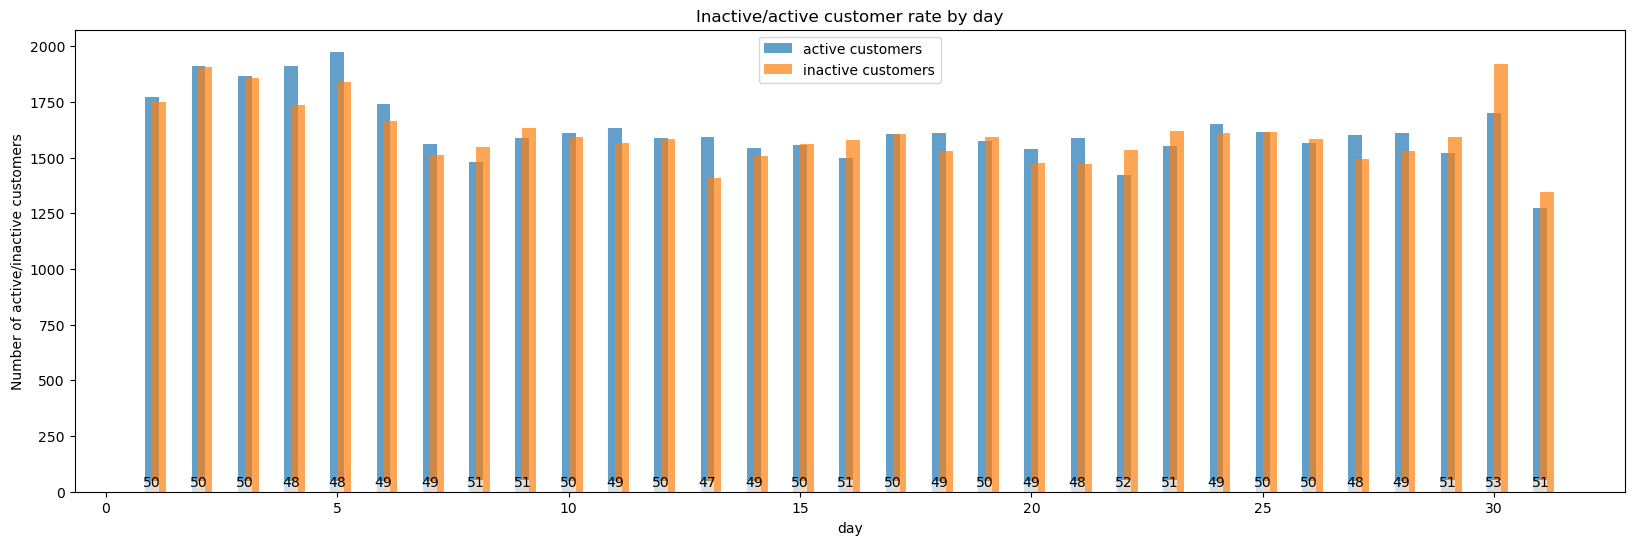

In [25]:
# (5년기준)비활성 고객의 월별 비율
num_a=[]
num_b=[]
p=[]
day=range(1,32,1)
for i in day:
    a=tranfinal_cus[(tranfinal_cus.join_day	==i)&(tranfinal_cus.payment_status=='Success')].groupby('customer_id').count().shape[0]
    b=(tranfinal_cus[(tranfinal_cus.join_day==i)].groupby('customer_id').count().shape[0])-a
    # print(a,b)
    num_a.append(a)
    num_b.append(b)
    result = round(b/(a+b)*100)
    p.append(result)


    # print(f'-----------{i}월----------')
    # print('비활성화고객수:',b)
    # print('활성화고객수:',a)
    # print('비활성고객율 ⭐',round(b/(a+b)*100,1),'%')
plt.figure(figsize=(20,6))
plt.bar(day,num_a, width=0.3, align='center', alpha=0.7)
plt.bar(day,num_b,width=0.3, align='edge', alpha=0.7)
plt.bar(day,p,width=0.3, align='center', alpha=0.7,color='white')
plt.xlabel('day')
plt.ylabel('Number of active/inactive customers')
plt.title('Inactive/active customer rate by day')
for i, j in zip(day, p):
    plt.text(i, 10, str(j), ha='center', va='bottom')


plt.legend(['active customers','inactive customers'])

#### 결제방식, 매출, 연령대별 분석, 구매 시 사용기기

Text(0.5, 1.0, 'Device used for purchase')

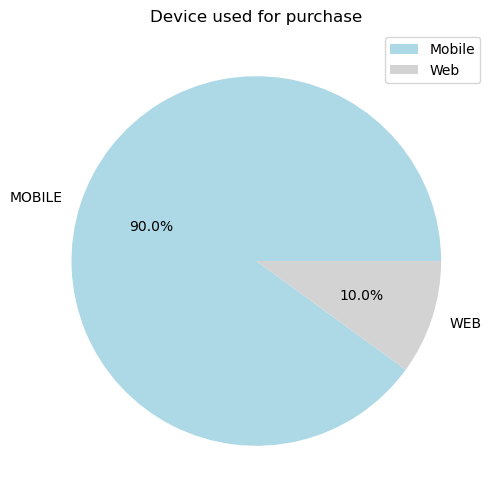

In [ ]:
traffic_counts = click_stream_new.groupby('session_id').agg({'traffic_source': 'first'}).reset_index().groupby('traffic_source').count()

# 데이터를 백분율로 변환
traffic_percentages = traffic_counts['session_id'] / traffic_counts['session_id'].sum() * 100

# 그래프 그리기
plt.figure(figsize=(6, 6))
colors = ['lightblue', 'lightgrey']  # 두 가지 색상 설정
plt.pie(traffic_percentages, labels=traffic_percentages.index, autopct='%1.1f%%', colors=colors)

plt.legend(['Mobile', 'Web'])
plt.title('Device used for purchase')

findfont: Font family ['NanumSquareNeo/TTF'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumSquareNeo/TTF'] not found. Falling back to DejaVu Sans.


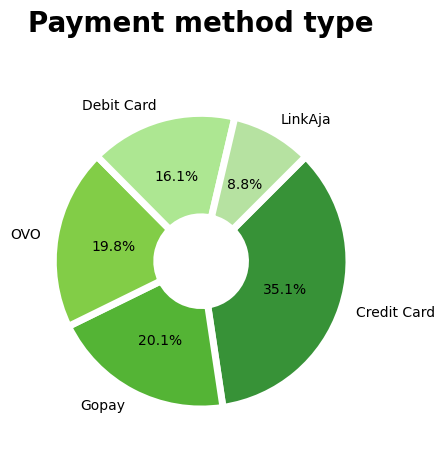

In [5]:
# 해당 이커머스 플랫폼의 결제방식 종류 -> COD(현장 결제 서비스)를 사용하지않음.
colors = [ '#379237','#54B435', '#82CD47','#ADE792', '#B6E2A1']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.title('Payment method type',fontsize=20,fontweight='bold',y=1.1)
tranfinal_cus.payment_method.value_counts().plot.pie(textprops={'size':10},colors=colors,wedgeprops=wedgeprops,autopct='%.1f%%',counterclock=False,startangle=45)
plt.ylabel('');

<AxesSubplot:xlabel='created_at_2'>

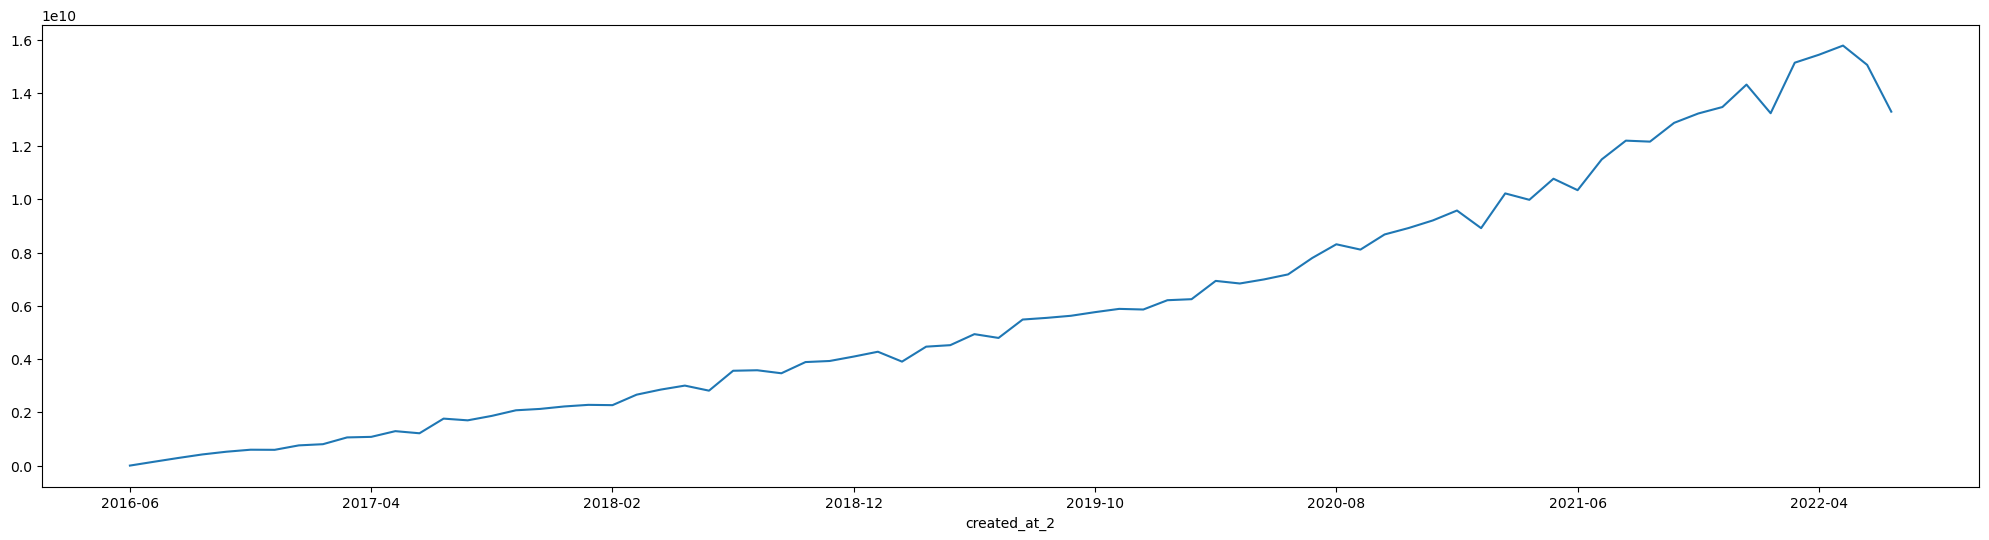

In [100]:
# (5년기준) 월별 매출 현황.
plt.figure(figsize=(25,6))
tranfinal_cus[tranfinal_cus.payment_status=='Success'].groupby('created_at_2')['total_amount'].sum().plot.line()

In [17]:
# 2020년~ 2022년 프로모션 적용여부에 따른 횟수, 매출
tranfinal_cus[tranfinal_cus.join_year > '2019'].groupby(['session_id']).agg({'promo_yesno':'first','total_amount':'sum'}).reset_index().groupby('promo_yesno')['total_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
promo_yesno,,,,,,,,
o,75354.00,545641.92,818777.65,19220.00,200324.25,298947.50,509579.00,21698815.00
x,212661.00,553564.61,822619.52,10898.00,206545.00,305740.00,517181.00,23504487.00


In [89]:
# 배송비에 따른 매출
print('배송비가 0인 경우의 총 매출 : ',tranfinal_cus[tranfinal_cus.shipment_fee==0]['total_amount'].sum()/tranfinal_cus['total_amount'].sum()*100)
print('배송비가 0이 아닌 경우의 총 매출 : ',tranfinal_cus[tranfinal_cus.shipment_fee!=0]['total_amount'].sum()/tranfinal_cus['total_amount'].sum()*100)

배송비가 0인 경우의 총 매출 :  25.408818979229803
배송비가 0이 아닌 경우의 총 매출 :  74.59118102077021


#### 일회성고객

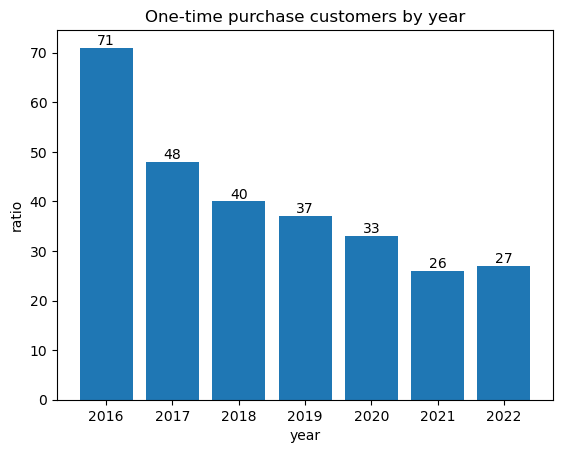

In [211]:
# 연도별 일회성 고객비율
q=[]
year=range(2016,2023)
for i in year:
    a=round(tranfinal_cus[(tranfinal_cus.created_at_5==f'{str(i)}')&(tranfinal_cus.payment_status=='Success')].groupby('customer_id')['session_id'].count().reset_index()['session_id'].value_counts(normalize=True).values[0]*100)
    q.append(a)

plt.bar(range(2016,2023), q)
plt.ylabel('ratio')
plt.xlabel('year')
plt.title('One-time purchase customers by year')
for i, j in zip(year, q):
    plt.text(i, j, str(j), ha='center', va='bottom');

Text(0.5, 1.0, 'Number of promotions used per year')

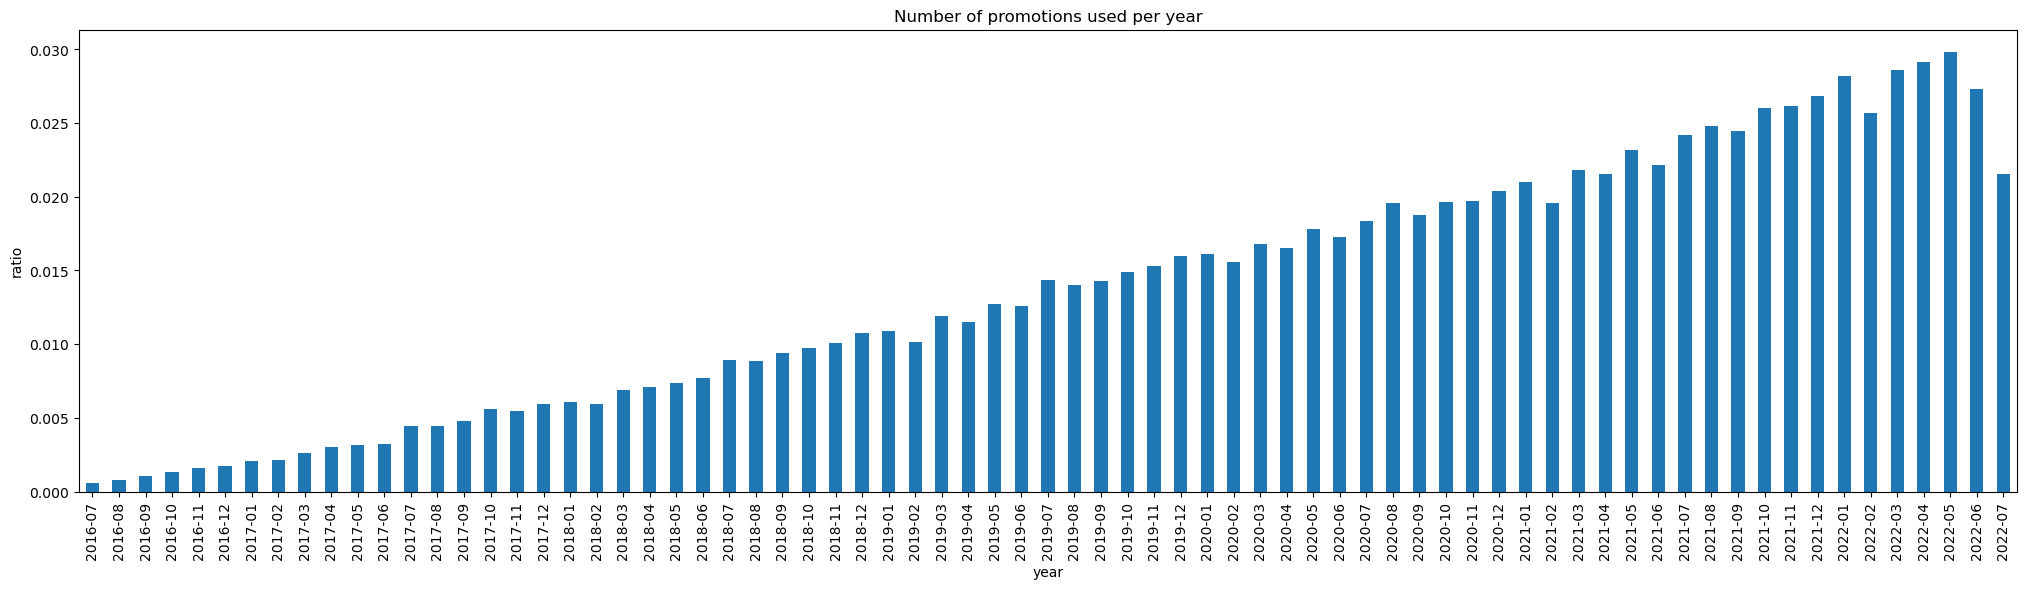

In [222]:
# 연도별 프로모션 사용횟수
plt.figure(figsize=(25,6))
(tranfinal_cus[tranfinal_cus.promo_yesno=='o'].groupby('created_at_2')['session_id'].count()/tranfinal_cus[tranfinal_cus.promo_yesno=='o'].groupby('created_at_2')['session_id'].count().sum()).plot.bar()
plt.xlabel('year')
plt.ylabel('ratio')
plt.title('Number of promotions used per year')

In [284]:
# 데이터 구조 변환, 2022년에 구매를 1번만 한 고객 파악
a=tranfinal_cus[(~tranfinal_cus.created_at.isnull())&(tranfinal_cus.created_at_5=='2022')&(tranfinal_cus.payment_status=='Success')].groupby('customer_id').agg({'session_id':['first','count']}).reset_index()
a.columns = [f'{col[0]}_{col[1]}' for col in a.columns]
tmp = a[a.session_id_count==1]
tmp['session_id_first'].values

array(['5f20fb20-8e35-4e30-a9d9-fc6a07d7835c',
       'cb1bb055-7431-4a77-b3e5-c896a9462aeb',
       '93c1fc1c-d261-4de7-87fd-609443e8a2e6', ...,
       'e279e5b6-5836-46b7-b726-59fda13bd298',
       'a33960ec-a151-4b8c-be81-6849a8fbeb23',
       '4fc4d81b-4b29-4aef-bd1f-263c373950d1'], dtype=object)

Text(0.5, 1.0, 'Promotion Applied vs. Promotion Not Applied')

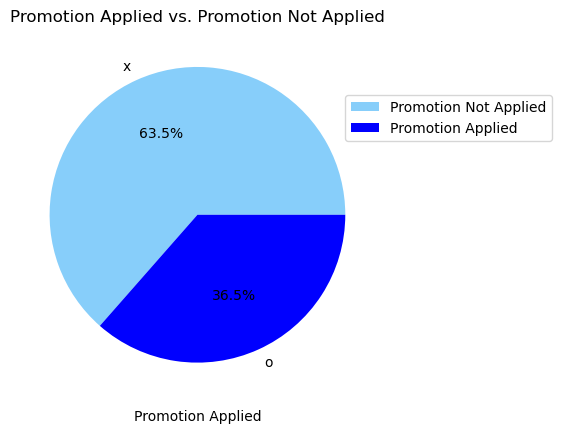

In [ ]:
# 일회성고객의 프로모션 사용비율
tmp_session = tranfinal_cus[tranfinal_cus.session_id.isin(tmp['session_id_first'].values)]

# 그래프 설정
colors = ['#87CEFA','b']
labels = ['Promotion Not Applied','Promotion Applied']

# 프로모션 적용 여부에 대한 비율을 계산하여 파이 차트 그리기
tmp_session.promo_yesno.value_counts(normalize=True).plot.pie(colors=colors, autopct='%1.1f%%')

# 기타 그래프 설정
plt.ylabel('')
plt.xlabel('Promotion Applied')
plt.legend(labels, loc=[0.9,0.7])
plt.title('Promotion Applied vs. Promotion Not Applied')

Text(0.5, 1.0, 'Promotion Applied vs. Promotion Not Applied')

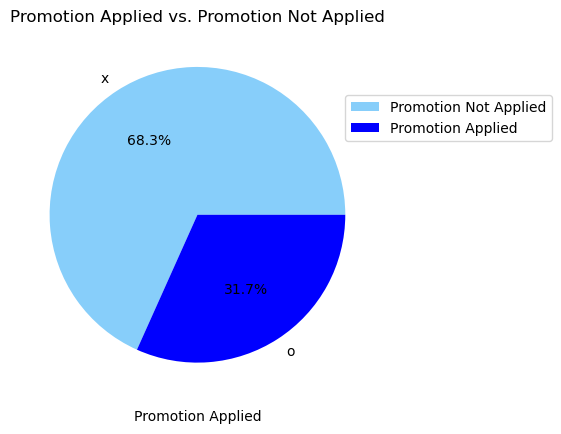

In [313]:
# 다회성고객의 프로모션 사용비율
tmp_session1 = tranfinal_cus[(~tranfinal_cus.session_id.isin(tmp['session_id_first'].values))&(tranfinal_cus.payment_status=='Success')&(tranfinal_cus.created_at_5=='2022')]

# 그래프 설정
colors = ['#87CEFA','b']
labels = ['Promotion Not Applied','Promotion Applied']

# 프로모션 적용 여부에 대한 비율을 계산하여 파이 차트 그리기
tmp_session1.promo_yesno.value_counts(normalize=True).plot.pie(colors=colors, autopct='%1.1f%%')

# 기타 그래프 설정
plt.ylabel('')
plt.xlabel('Promotion Applied')
plt.legend(labels, loc=[0.9,0.7])
plt.title('Promotion Applied vs. Promotion Not Applied')

In [287]:
# 다회성고객 추출한 데이터
tmp_session1 = tranfinal_cus[(~tranfinal_cus.session_id.isin(tmp['session_id_first'].values))&(tranfinal_cus.payment_status=='Success')&(tranfinal_cus.created_at_5=='2022')]

Text(0.5, 1.0, 'Average Purchase Amount by Customer Type')

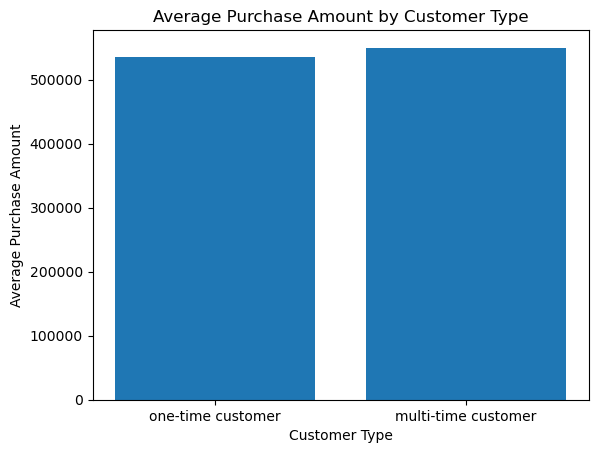

In [289]:
# 2022년의 일회성, 다회성 고객의 객단가
data = [tmp_session['total_amount'].sum() / len(tmp_session), tmp_session1['total_amount'].sum() / len(tmp_session1)]
x_labels = ['one-time customer', 'multi-time customer']

plt.bar(range(len(data)), data)
plt.xticks(range(len(data)), x_labels)
plt.xlabel('Customer Type')
plt.ylabel('Average Purchase Amount')
plt.title('Average Purchase Amount by Customer Type')

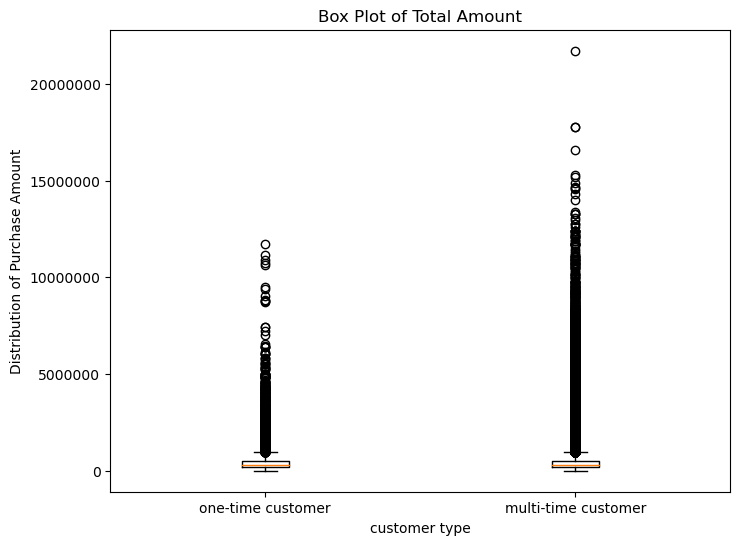

In [279]:
# 일회성 고객과 다회성 고객의 구매금액 분포
data = [tmp_session['total_amount'], tmp_session1['total_amount']]

plt.figure(figsize=(8, 6))
plt.boxplot(data)
plt.xticks([1, 2], ['one-time customer', 'multi-time customer'])
plt.xlabel('customer type')
plt.ylabel('Distribution of Purchase Amount')
plt.title('Box Plot of Total Amount')
plt.gca().get_yaxis().get_major_formatter().set_scientific(False);

1035362068.0 1889
979406413.0 1864
1362040694.0 2488
939166242.0 1767
165032084.0 323
115916743.0 223
127415397.0 280


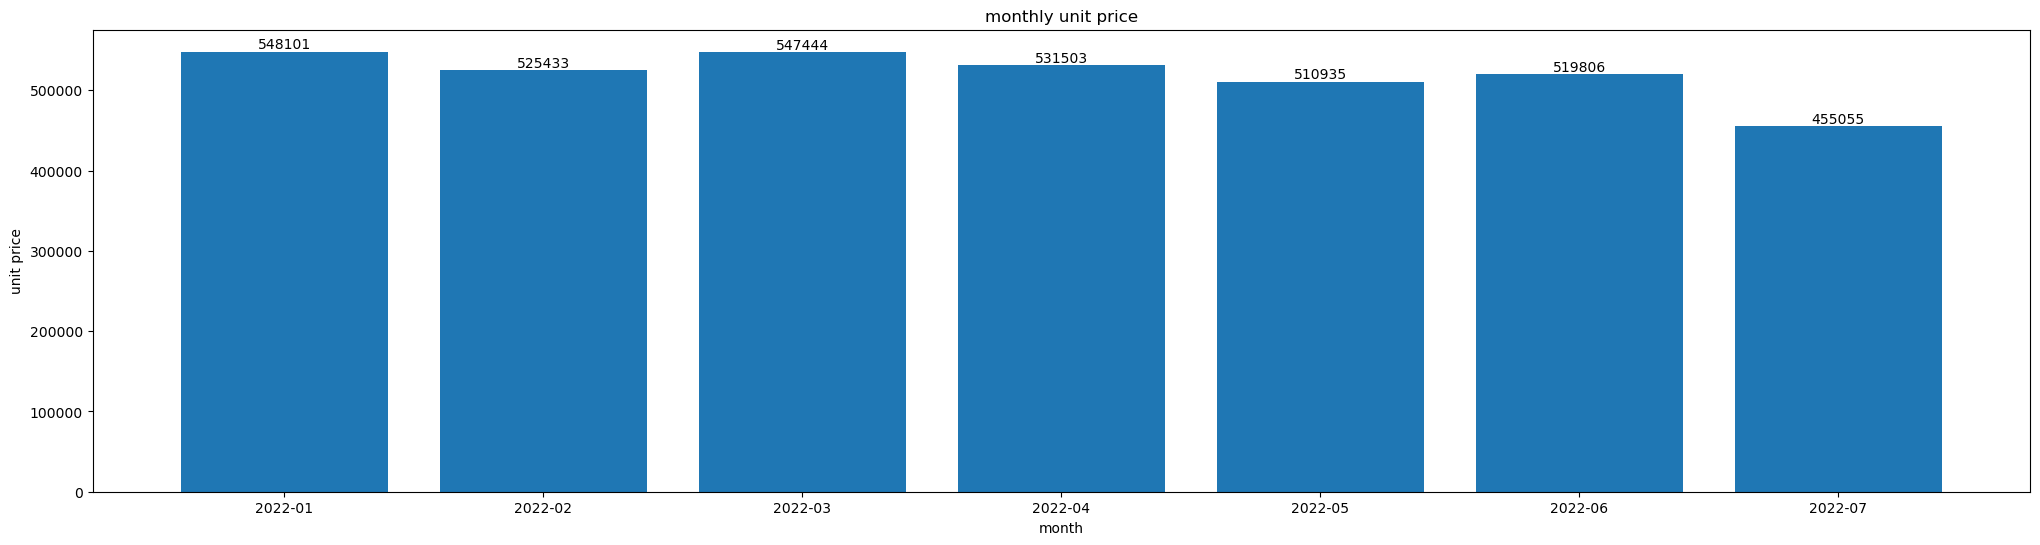

In [312]:
# 2022년도 일회성고객의 월별 객단가 - 7월이 가장 낮긴함.
q=[]
plt.figure(figsize=(25,6))
lis=sorted(tmp_session.created_at_2.unique())
for i in lis:
    top = tmp_session[(tmp_session.payment_status=='Success')&(tmp_session.created_at_2==f'{i}')]['total_amount'].sum()
    down=tmp_session[(tmp_session.payment_status=='Success')&(tmp_session.created_at_2==f'{i}')].groupby('session_id').count().shape[0]
    print(top,down)
    q.append(round(top / down))

plt.bar(lis, q)

plt.xlabel('month')
plt.ylabel('unit price')
plt.title('monthly unit price')
plt.xticks(rotation=0)
for i, j in zip(lis,q):
    plt.text(i, j, round(j, 1), ha='center', va='bottom');

In [254]:
# 일회성 고객들의 주로 어떤 제품 구매하는지 파악.
new_tmp_session = pd.merge(tmp_session, new, on='session_id', how='left')
new_tmp = pd.merge(new_tmp_session,product, left_on='product_id', right_on='id', how='left')

# 일회성 고객이 가장 많이 구매한 subCategory
new_tmp.subCategory.value_counts(normalize=True)

,created_at_x,customer_id_x,promo_amount_x,shipment_fee_x,total_amount_x,quantity_x,shipment_period,booking_id_x,session_id,promo_code_x,payment_method_x,payment_status_x,promo_yesno,created_at_2,gender_x,birthdate,device_type,first_join_date,join_date,join_month,join_day,join_year,created_at_3,created_at_5,가입 후 첫구매까지의 기간,age,age2,created_at_y,customer_id_y,booking_id_y,payment_method_y,payment_status_y,promo_amount_y,promo_code_y,shipment_fee_y,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount_y,product_id,quantity_y,item_price,id,gender_y,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,2022-04-22 10:59:41,96453,10603.00,10000.00,229579.00,1.00,3 days 01:13:06,8d7db006-cdac-403c-a344-8dfac3b89dc9,96604ca8-3d09-4a88-9b9d-7e6b4ec28e1b,SC2022,OVO,Success,o,2022-04,F,2005-02-12,Android,2022-01-09,2022-01,01,09,2022,2022-04-22,2022,103.00,18,10,2022-04-22T10:59:41.347108Z,96453,8d7db006-cdac-403c-a344-8dfac3b89dc9,OVO,Success,10603,SC2022,10000,2022-04-25T12:12:47.479743Z,-6.33,106.87,229579,16213,1,230182,16213.00,Men,Apparel,Topwear,Tshirts,White,Fall,2011.00,Sports,Puma Men Training White TShirt
1,2022-01-27 00:57:49,73093,3397.00,0.00,334462.00,1.00,1 days 14:24:56,412a5c16-1fa6-4be0-894f-f82d8358553d,f4e4a2d1-909c-4842-ab57-995048771485,AZ2022,Debit Card,Success,o,2022-01,F,1992-01-06,Android,2021-07-24,2021-07,07,24,2021,2022-01-27,2022,187.00,31,30,2022-01-27T00:57:49.312307Z,73093,412a5c16-1fa6-4be0-894f-f82d8358553d,Debit Card,Success,3397,AZ2022,0,2022-01-28T15:22:45.473665Z,-7.38,108.95,334462,1924,1,337859,1924.00,Men,Apparel,Topwear,Tshirts,White,Fall,2010.00,Sports,Puma Mens Racing White T-shirt
2,2022-02-02 04:41:37,97883,4194.00,10000.00,276895.00,1.00,3 days 07:28:41,85815407-020e-4da3-8f9e-48095cbb3990,1e7731c5-be78-402d-ad96-d05034943f27,AZ2022,Debit Card,Success,o,2022-02,F,1999-08-24,Android,2017-07-30,2017-07,07,30,2017,2022-02-02,2022,1648.00,23,20,2022-02-02T04:41:37.328573Z,97883,85815407-020e-4da3-8f9e-48095cbb3990,Debit Card,Success,4194,AZ2022,10000,2022-02-05T12:10:18.309104Z,-9.58,119.31,276895,38606,1,271089,38606.00,Men,Apparel,Topwear,Tshirts,White,Summer,2012.00,Casual,Nike Men Printed Boxed White T-shirt
3,2022-04-11 00:16:52,31163,0.00,0.00,176380.00,1.00,5 days 12:02:59,eb7d3c67-dea8-4de6-97ac-042f06ff026c,12b832fb-4037-4e5c-8630-fe0ed0e8507d,Nopromo,Credit Card,Success,x,2022-04,F,2003-04-11,Android,2020-03-08,2020-03,03,08,2020,2022-04-11,2022,764.00,20,20,2022-04-11T00:16:52.076850Z,31163,eb7d3c67-dea8-4de6-97ac-042f06ff026c,Credit Card,Success,0,NaN,0,2022-04-16T12:19:51.786414Z,-5.48,105.81,176380,56485,1,176380,56485.00,Women,Personal Care,Nails,Nail Polish,Black,Spring,2017.00,NaN,Streetwear Black Magic Nail Polish # 80
4,2022-02-04 00:40:24,6487,0.00,0.00,342180.00,2.00,2 days 17:36:08,c2d24a7b-90b7-4b6c-ae12-9a2787e36c4d,400eb863-c221-4df2-a080-fe6674c845f8,Nopromo,Gopay,Success,x,2022-02,F,2000-08-22,Android,2021-02-14,2021-02,02,14,2021,2022-02-04,2022,355.00,22,20,2022-02-04T00:40:24.619157Z,6487,c2d24a7b-90b7-4b6c-ae12-9a2787e36c4d,Gopay,Success,0,NaN,0,2022-02-06T18:16:32.205730Z,-7.50,131.39,342180,28541,2,171090,28541.00,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.00,Sports,Nike Men Running Grey T-shirt


In [256]:
# 일회성 고객데이터와 클릭데이터 merge
click_product = pd.merge(click_stream_new,tmp_session,on='session_id',how='right')

In [259]:
# merge한 데이터에 분석을 위한 요일, 년,일 컬럼 생성.
click_product['created_at'] = click_product['created_at'].astype('datetime64')
click_product['created_at_2'] = click_product['created_at'].dt.strftime('%Y')
click_product['created_at3'] = click_product['created_at'].dt.strftime('%Y-%m-%d').astype('datetime64')
click_product['week'] =  click_product['created_at3'].dt.weekday
click_product = click_product[click_product.created_at_2 > '2019']
click_product.head()

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity_x,item_price,payment_status_x,search_keywords,promo_code_x,promo_amount_x,created_at,customer_id,promo_amount_y,shipment_fee,total_amount,quantity_y,shipment_period,booking_id,promo_code_y,payment_method,payment_status_y,promo_yesno,created_at_2,gender,birthdate,device_type,first_join_date,join_date,join_month,join_day,join_year,created_at_3,created_at_5,가입 후 첫구매까지의 기간,age,age2,created_at3,week
0,96604ca8-3d09-4a88-9b9d-7e6b4ec28e1b,HOMEPAGE,2022-04-01T22:35:34.347108Z,97bf5665-1c70-4e33-bb64-a8f39a6e4fb1,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-22 10:59:41,96453,10603.00,10000.00,229579.00,1.00,3 days 01:13:06,8d7db006-cdac-403c-a344-8dfac3b89dc9,SC2022,OVO,Success,o,2022,F,2005-02-12,Android,2022-01-09,2022-01,01,09,2022,2022-04-22,2022,103.00,18,10,2022-04-22,4
1,96604ca8-3d09-4a88-9b9d-7e6b4ec28e1b,ADD_TO_CART,2022-04-03T19:31:54.347108Z,dff80fe1-b9ce-471b-b534-3f8813461039,MOBILE,16213.00,1.00,230182.00,NaN,NaN,NaN,NaN,2022-04-22 10:59:41,96453,10603.00,10000.00,229579.00,1.00,3 days 01:13:06,8d7db006-cdac-403c-a344-8dfac3b89dc9,SC2022,OVO,Success,o,2022,F,2005-02-12,Android,2022-01-09,2022-01,01,09,2022,2022-04-22,2022,103.00,18,10,2022-04-22,4
2,96604ca8-3d09-4a88-9b9d-7e6b4ec28e1b,ADD_PROMO,2022-04-05T16:18:20.347108Z,45436abf-e21b-4e4e-9514-f576fda6e478,MOBILE,NaN,NaN,NaN,NaN,NaN,SC2022,10603.00,2022-04-22 10:59:41,96453,10603.00,10000.00,229579.00,1.00,3 days 01:13:06,8d7db006-cdac-403c-a344-8dfac3b89dc9,SC2022,OVO,Success,o,2022,F,2005-02-12,Android,2022-01-09,2022-01,01,09,2022,2022-04-22,2022,103.00,18,10,2022-04-22,4
3,96604ca8-3d09-4a88-9b9d-7e6b4ec28e1b,BOOKING,2022-04-22T10:59:41.347108Z,b4b86c25-317a-4b01-8c8f-53f8c7a6702d,MOBILE,NaN,NaN,NaN,Success,NaN,NaN,NaN,2022-04-22 10:59:41,96453,10603.00,10000.00,229579.00,1.00,3 days 01:13:06,8d7db006-cdac-403c-a344-8dfac3b89dc9,SC2022,OVO,Success,o,2022,F,2005-02-12,Android,2022-01-09,2022-01,01,09,2022,2022-04-22,2022,103.00,18,10,2022-04-22,4
4,96604ca8-3d09-4a88-9b9d-7e6b4ec28e1b,SEARCH,2022-04-03T19:21:46.347108Z,e368acad-7930-481c-a671-5ea9b6c8576f,MOBILE,NaN,NaN,NaN,NaN,Dress Kondangan,NaN,NaN,2022-04-22 10:59:41,96453,10603.00,10000.00,229579.00,1.00,3 days 01:13:06,8d7db006-cdac-403c-a344-8dfac3b89dc9,SC2022,OVO,Success,o,2022,F,2005-02-12,Android,2022-01-09,2022-01,01,09,2022,2022-04-22,2022,103.00,18,10,2022-04-22,4


In [263]:
# 일회성 고객의 주요 구매 제품.
click_product.search_keywords.value_counts(normalize=True)

Dress Kondangan   0.23
Tas Wanita        0.11
Bekas             0.10
T-Shirt           0.08
Kaos              0.07
Baju              0.07
Dress Pesta       0.07
Sepatu Nike       0.05
Tas Kerja         0.03
Celana Panjang    0.03
Sepatu            0.03
Thrift            0.03
Second            0.03
Barang Bekas      0.02
Second Hand       0.02
Sepatu Adidas     0.02
Sendal            0.01
Celana            0.01
T-shirt           0.00
Jam               0.00
Topi              0.00
Baju Tidur        0.00
Daster            0.00
Name: search_keywords, dtype: float64

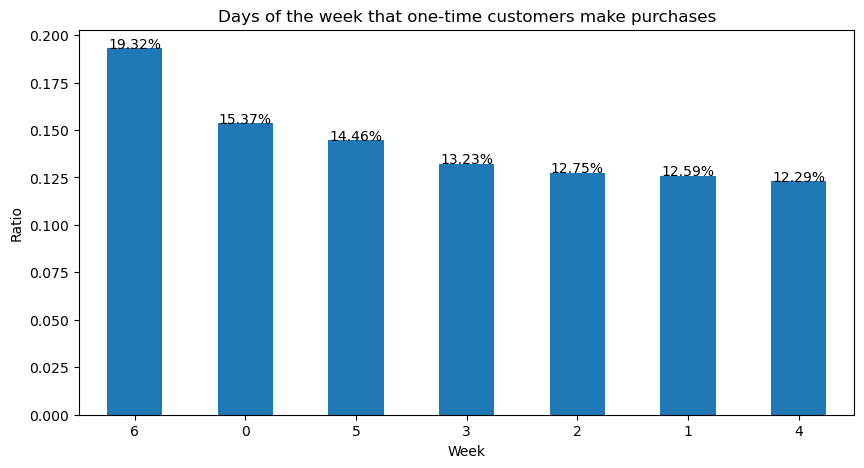

In [268]:
# 일회성 고객의 주요 구매 요일 파악. - 일요일이 19%로 가장 많이 차지.
plt.figure(figsize=(10, 5))
ax = click_product.week.value_counts(normalize=True).plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Week')
plt.ylabel('Ratio')
plt.title('Days of the week that one-time customers make purchases')

# Add values on top of the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x + width / 2, y + height, f'{height:.2%}', ha='center')

plt.show()

979612038.0
2560847601.0
--------------
2041863698.0
17969732326.0
--------------
3017705698.0
38417047666.0
--------------
3959417858.0
61083778169.0
--------------
5144789382.0
91455407092.0
--------------
5097541076.0
135273387102.0
--------------
4724339641.0
102237044152.0
--------------


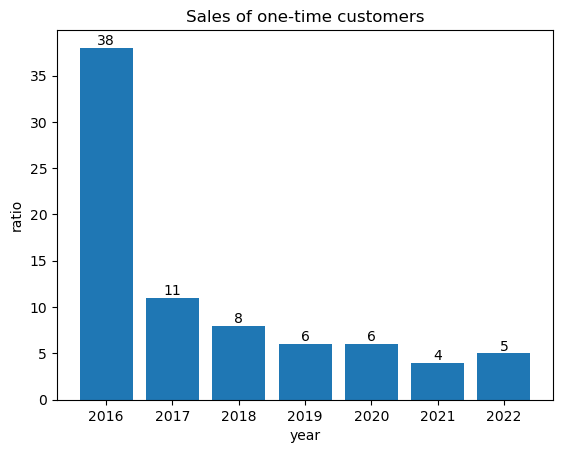

In [244]:
# 일회성고객이 차지하는 매출비중
q=[]
lis = range(2016,2023)
for i in lis:
    a=tranfinal_cus[(tranfinal_cus.payment_status=='Success')&(tranfinal_cus.created_at_5==f'{str(i)}')].groupby('customer_id').agg({'session_id':'count','total_amount':'sum'}).reset_index()
    aa=a[a.session_id==1]['total_amount'].sum()
    # print(aa)
    b=tranfinal_cus[(tranfinal_cus.payment_status=='Success')&(tranfinal_cus.created_at_5==f'{str(i)}')]['total_amount'].sum()
    # print(b)
    # print('--------------')

    c=round(aa/b*100)

    q.append(c)

plt.bar(range(2016,2023), q)
plt.ylabel('ratio')
plt.xlabel('year')
plt.title('Sales of one-time customers')
for i, j in zip(lis, q):
    plt.text(i, j, str(j), ha='center', va='bottom');

#### 재구매율

  2016년도 재구매율(1회 구매한 고객 중 재구매한 고객수/1번이라도 구매한 고객수) :  29.2
  2017년도 재구매율(1회 구매한 고객 중 재구매한 고객수/1번이라도 구매한 고객수) :  51.5
  2018년도 재구매율(1회 구매한 고객 중 재구매한 고객수/1번이라도 구매한 고객수) :  60.1
  2019년도 재구매율(1회 구매한 고객 중 재구매한 고객수/1번이라도 구매한 고객수) :  63.5
  2020년도 재구매율(1회 구매한 고객 중 재구매한 고객수/1번이라도 구매한 고객수) :  67.0
  2021년도 재구매율(1회 구매한 고객 중 재구매한 고객수/1번이라도 구매한 고객수) :  74.0
  2022년도 재구매율(1회 구매한 고객 중 재구매한 고객수/1번이라도 구매한 고객수) :  72.8


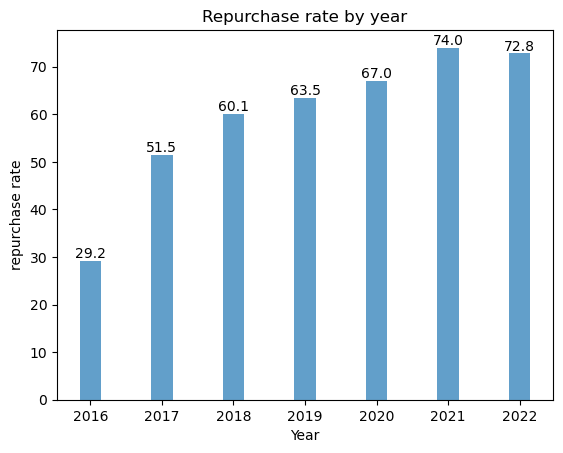

In [96]:
#(5년기준)고객들의 재구매율
p=[]
for i in range(2016,2023,1):
    # <<<<216~2022년 기준으로 구함>>>>

    # 2022년도에 1번이상 구매한 사람
    tran_rebuy = tranfinal_cus[(tranfinal_cus.created_at.dt.year== i)&(tranfinal_cus.payment_status=='Success')].groupby('customer_id')['session_id'].count().reset_index()
    # 2022년도에 재구매율
    tran_rebuy3 = tran_rebuy[tran_rebuy.session_id != 1]
    p.append(round(tran_rebuy3.shape[0]/tran_rebuy.shape[0]*100,1))
    print(f'  {i}년도 재구매율(1회 구매한 고객 중 재구매한 고객수/1번이라도 구매한 고객수) : ',round(tran_rebuy3.shape[0]/tran_rebuy.shape[0]*100,1))


plt.bar(years,p,width=0.3, align='center', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('repurchase rate')
plt.title('Repurchase rate by year')
for i, j in zip(years, p):
    plt.text(i, j, str(j), ha='center', va='bottom')

 ⭐<2016년도> 프로모션 코드를 적용한 고객의 재구매율 :  40.4
 ⭐<2017년도> 프로모션 코드를 적용한 고객의 재구매율 :  67.7
 ⭐<2018년도> 프로모션 코드를 적용한 고객의 재구매율 :  74.2
 ⭐<2019년도> 프로모션 코드를 적용한 고객의 재구매율 :  77.2
 ⭐<2020년도> 프로모션 코드를 적용한 고객의 재구매율 :  81.6
 ⭐<2021년도> 프로모션 코드를 적용한 고객의 재구매율 :  86.7
 ⭐<2022년도> 프로모션 코드를 적용한 고객의 재구매율 :  85.4
 ❌<2016년도> 프로모션 코드를 적용한 고객의 재구매율 :  42.23
 ❌<2017년도> 프로모션 코드를 적용한 고객의 재구매율 :  63.69
 ❌<2018년도> 프로모션 코드를 적용한 고객의 재구매율 :  72.16
 ❌<2019년도> 프로모션 코드를 적용한 고객의 재구매율 :  74.79
 ❌<2020년도> 프로모션 코드를 적용한 고객의 재구매율 :  75.78
 ❌<2021년도> 프로모션 코드를 적용한 고객의 재구매율 :  80.8
 ❌<2022년도> 프로모션 코드를 적용한 고객의 재구매율 :  80.07


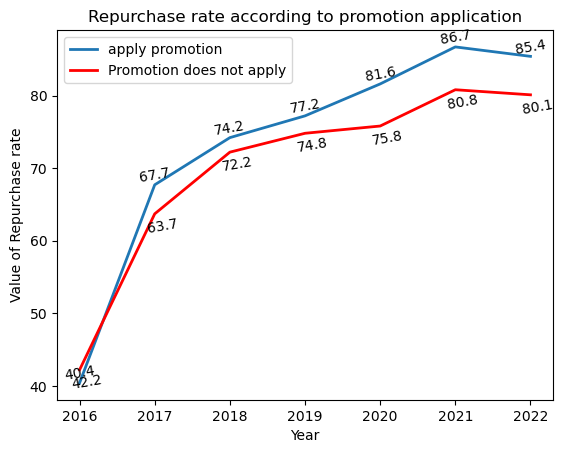

In [53]:
#(5년기준) 프로모션 적용여부에 따른 재구매율
p= []
years=range(2016,2023,1)
for i in range(2016,2023,1):

    # 해당기간에 프로모션을 사용하지않고 1회이상 구매한 고객 수
    # tran_rebuy = tranfinal_cus[(tranfinal_cus.created_at.dt.year==i)&(tranfinal_cus.payment_status=='Success')&(tranfinal_cus.promo_yesno=='o')].groupby('customer_id')['session_id'].count().reset_index()
    a=tranfinal_cus[(tranfinal_cus.created_at_3.dt.year==i)&(tranfinal_cus.payment_status=='Success')&(tranfinal_cus.promo_yesno=='o')].groupby('customer_id')['session_id'].count().reset_index()['customer_id']
    b=tranfinal_cus[(tranfinal_cus.customer_id.isin(a.values))&(tranfinal_cus.created_at_3.dt.year==i)&(tranfinal_cus.payment_status=='Success')].groupby('customer_id')['session_id'].count().reset_index()
    tran_rebuy_upper=b[b.session_id>1]
    # 해당기간에 프로모션을 사용하여 1회이상 구매하고 추가로 구매한 고객수
    p.append(round(tran_rebuy_upper.shape[0]/a.shape[0]*100,1))
    print(f' ⭐<{i}년도> 프로모션 코드를 적용한 고객의 재구매율 : ',round(tran_rebuy_upper.shape[0]/a.shape[0]*100,1))

plt.plot(years,p,lw=2)
plt.xlabel('Year')
plt.ylabel('Value of Repurchase rate')
plt.title('Repurchase rate according to promotion application');
for i, j in zip(years, p):
    plt.text(i, j, str(j), ha='center', va='bottom', rotation=10)

q = []
years=range(2016,2023,1)
for i in range(2016,2023,1):

    # 해당기간에 프로모션을 사용하지않고 1회이상 구매한 고객 수
    # tran_rebuy = tranfinal_cus[(tranfinal_cus.created_at.dt.year==i)&(tranfinal_cus.payment_status=='Success')&(tranfinal_cus.promo_yesno=='o')].groupby('customer_id')['session_id'].count().reset_index()
    a=tranfinal_cus[(tranfinal_cus.created_at_3.dt.year==i)&(tranfinal_cus.payment_status=='Success')&(tranfinal_cus.promo_yesno=='x')].groupby('customer_id')['session_id'].count().reset_index()['customer_id']
    b=tranfinal_cus[(tranfinal_cus.customer_id.isin(a.values))&(tranfinal_cus.created_at_3.dt.year==i)&(tranfinal_cus.payment_status=='Success')].groupby('customer_id')['session_id'].count().reset_index()
    tran_rebuy_upper=b[b.session_id>1]
    q.append(round(tran_rebuy_upper.shape[0]/a.shape[0]*100,1))
    # 해당기간에 프로모션을 사용하여 1회이상 구매하고 추가로 구매한 고객수
    print(f' ❌<{i}년도> 프로모션 코드를 적용한 고객의 재구매율 : ',round(tran_rebuy_upper.shape[0]/a.shape[0]*100,2))
plt.plot(years,q,lw=2,color='r')
p
for i, j in zip(years, q):
    plt.text(i+0.1, j-3, str(j), ha='center', va='bottom', rotation=10)

plt.legend(['apply promotion','Promotion does not apply'])

Nopromo 프로모션 코드를 적용한 고객의 재구매율:  42.2
Nopromo 프로모션 코드를 적용한 고객의 재구매율:  63.7
Nopromo 프로모션 코드를 적용한 고객의 재구매율:  72.2
Nopromo 프로모션 코드를 적용한 고객의 재구매율:  74.8
Nopromo 프로모션 코드를 적용한 고객의 재구매율:  75.8
Nopromo 프로모션 코드를 적용한 고객의 재구매율:  80.8
Nopromo 프로모션 코드를 적용한 고객의 재구매율:  80.1
AZ2022 프로모션 코드를 적용한 고객의 재구매율:  58.3
AZ2022 프로모션 코드를 적용한 고객의 재구매율:  84.1
AZ2022 프로모션 코드를 적용한 고객의 재구매율:  87.6
AZ2022 프로모션 코드를 적용한 고객의 재구매율:  89.8
AZ2022 프로모션 코드를 적용한 고객의 재구매율:  90.8
AZ2022 프로모션 코드를 적용한 고객의 재구매율:  93.6
AZ2022 프로모션 코드를 적용한 고객의 재구매율:  92.0
BUYMORE 프로모션 코드를 적용한 고객의 재구매율:  61.1
BUYMORE 프로모션 코드를 적용한 고객의 재구매율:  85.7
BUYMORE 프로모션 코드를 적용한 고객의 재구매율:  88.5
BUYMORE 프로모션 코드를 적용한 고객의 재구매율:  90.6
BUYMORE 프로모션 코드를 적용한 고객의 재구매율:  92.3
BUYMORE 프로모션 코드를 적용한 고객의 재구매율:  94.5
BUYMORE 프로모션 코드를 적용한 고객의 재구매율:  92.7
WEEKENDSERU 프로모션 코드를 적용한 고객의 재구매율:  44.7
WEEKENDSERU 프로모션 코드를 적용한 고객의 재구매율:  76.9
WEEKENDSERU 프로모션 코드를 적용한 고객의 재구매율:  83.3
WEEKENDSERU 프로모션 코드를 적용한 고객의 재구매율:  85.5
WEEKENDSERU 프로모션 코드를 적용한 고객의 재구매율:  89.7
WEEKENDSERU 프로모션 코드를 적용한 

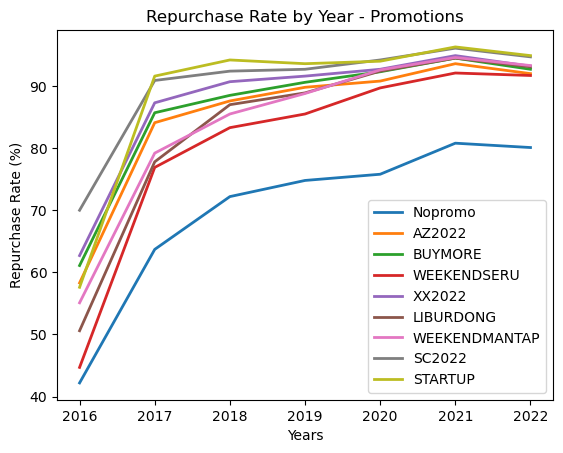

In [ ]:
import matplotlib.pyplot as plt

years = range(2016, 2023, 1)
promo_codes = tranfinal_cus.promo_code.value_counts().index
legend_labels = []

for code in promo_codes:
    p = []
    for i in years:
        a = tranfinal_cus[(tranfinal_cus.created_at_3.dt.year == i) & (tranfinal_cus.payment_status == 'Success') & (tranfinal_cus.promo_code == code)].groupby('customer_id')['session_id'].count().reset_index()['customer_id']
        b = tranfinal_cus[(tranfinal_cus.customer_id.isin(a.values)) & (tranfinal_cus.created_at_3.dt.year == i) & (tranfinal_cus.payment_status == 'Success')].groupby('customer_id')['session_id'].count().reset_index()
        tran_rebuy_upper = b[b.session_id > 1]
        # 해당 기간에 프로모션을 사용하여 1회 이상 구매하고 추가로 구매한 고객수
        p.append(round(tran_rebuy_upper.shape[0] / a.shape[0] * 100, 1))
        # print(f'{code} 프로모션 코드를 적용한 고객의 재구매율: ', round(tran_rebuy_upper.shape[0] / a.shape[0] * 100, 1))
    
    plt.plot(years, p, lw=2)
    legend_labels.append(code)  # 프로모션 코드를 레전드 라벨에 추가
    
plt.xlabel('Years')
plt.ylabel('Repurchase Rate (%)')
plt.title('Repurchase Rate by Year - Promotions')
plt.legend(legend_labels)  # 레전드 라벨 표시
plt.show()

In [42]:
# 주문날짜에서 월만 추출
mask = tranfinal_cus['created_at'].notnull()
tranfinal_cus.loc[mask, 'month'] = pd.to_datetime(tranfinal_cus.loc[mask, 'created_at']).dt.strftime('%m')
tranfinal_cus.head()

,created_at,customer_id,promo_amount,shipment_fee,total_amount,quantity,shipment_period,booking_id,session_id,promo_code,payment_method,payment_status,promo_yesno,created_at_2,gender,birthdate,device_type,home_location,first_join_date,join_date,join_month,join_day,join_year,created_at_3,가입 후 첫구매까지의 기간,month
0,NaN,2870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,1996-06-14,iOS,Sumatera Barat,2019-07-21,2019-07,07,21,2019,NaT,-1.00,NaN
1,NaN,8193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,1993-08-16,Android,Jakarta Raya,2017-07-16,2017-07,07,16,2017,NaT,-1.00,NaN
2,2020-08-23 12:53:12,7279,2853.00,15000.00,844751.00,3.00,2 days 16:20:52,1fb6f149-05ef-4a22-ac1a-cd5d98cd5510,9d0496a6-37f7-4d0a-8a04-5850a12d00a6,WEEKENDSERU,LinkAja,Success,o,2020-08,M,1989-01-23,iOS,Nusa Tenggara Barat,2020-08-23,2020-08,08,23,2020,2020-08-23,0.00,08
3,2020-08-31 13:34:59,7279,0.00,10000.00,391341.00,1.00,3 days 16:14:02,eed52035-1f80-422c-b0ac-a1c814e77bcf,82396d8d-7d8a-436d-8e14-75f24aa35faa,Nopromo,LinkAja,Success,x,2020-08,M,1989-01-23,iOS,Nusa Tenggara Barat,2020-08-23,2020-08,08,23,2020,2020-08-31,8.00,08
4,2020-09-08 13:38:30,7279,0.00,0.00,154220.00,1.00,5 days 21:47:50,af568d06-c819-4ab4-a3e8-06857786ba10,348cc997-480b-467e-a502-1eed0f611e9d,Nopromo,LinkAja,Success,x,2020-09,M,1989-01-23,iOS,Nusa Tenggara Barat,2020-08-23,2020-08,08,23,2020,2020-09-08,16.00,09


(최근 2년) 구매 후 30일 이내 재구매율: 14.2%
(최근 2년) 구매 후 30일 이내 재구매율: 19.9%
(최근 2년) 구매 후 30일 이내 재구매율: 15.0%
(최근 2년) 구매 후 60일 이내 재구매율: 12.0%
(최근 2년) 구매 후 90일 이내 재구매율: 8.8%


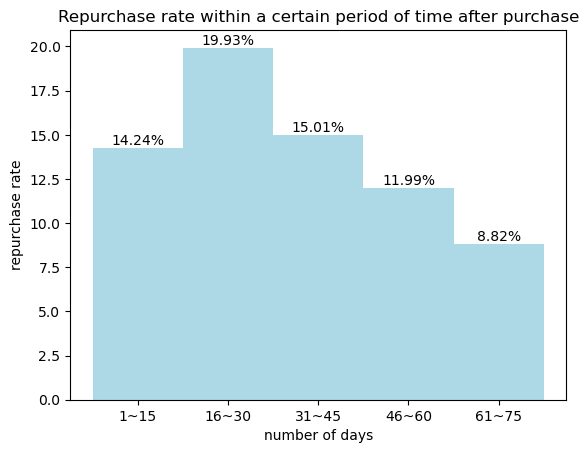

In [195]:
q = []
month_day = [15, 30, 45, 60, 75]

# 새로운 코드 추가
tranfinal_cus_2 = tranfinal_cus[tranfinal_cus.created_at.notnull()]
tranfinal_cus_2['created_at'] = pd.to_datetime(tranfinal_cus_2['created_at'])
tranfinal_cus_2['created_at_3'] = tranfinal_cus_2['created_at'].dt.strftime('%Y-%m-%d')
tranfinal_cus_22 = tranfinal_cus_2[(tranfinal_cus_2.created_at_3 >= '2020-08-01') & (tranfinal_cus.payment_status == 'Success')]

customer_purchase = tranfinal_cus_22.sort_values(by=['customer_id', 'created_at'])
customer_purchase['diff'] = customer_purchase.groupby('customer_id')['created_at'].diff()
customer_purchase.dropna(subset=['diff'], inplace=True)

def Repurchase_rate(first, day):
    repurchases_within_period = customer_purchase[(customer_purchase['diff'] > pd.Timedelta(days=first)) & (customer_purchase['diff'] <= pd.Timedelta(days=day))]
    repurchase_count = len(repurchases_within_period['customer_id'].unique())
    total_customers = len(customer_purchase['customer_id'].unique())
    repurchase_rate = repurchase_count / total_customers
    return repurchase_rate

print(f"(최근 2년) 구매 후 30일 이내 재구매율: {Repurchase_rate(0, 15):.1%}")
q.append(round(Repurchase_rate(0, 15), 4)*100)
print(f"(최근 2년) 구매 후 30일 이내 재구매율: {Repurchase_rate(16, 30):.1%}")
q.append(round(Repurchase_rate(16, 30), 4)*100)
print(f"(최근 2년) 구매 후 30일 이내 재구매율: {Repurchase_rate(31, 45):.1%}")
q.append(round(Repurchase_rate(31, 45), 4)*100)
print(f"(최근 2년) 구매 후 60일 이내 재구매율: {Repurchase_rate(46, 60):.1%}")
q.append(round(Repurchase_rate(46, 60), 4)*100)
print(f"(최근 2년) 구매 후 90일 이내 재구매율: {Repurchase_rate(61, 75):.1%}")
q.append(round(Repurchase_rate(61, 75), 4)*100)

plt.bar(month_day, q, lw=3, color='lightblue', width=15)
plt.xlabel('number of days')
plt.ylabel('repurchase rate')
plt.xticks(month_day, ['0~15', '16~30', '31~45', '46~60', '61~75'], ha='center')
plt.title('Repurchase rate within a certain period of time after purchase')
for i, j in zip(month_day, q):
    plt.text(i, j, str(round(j,2))+'%', ha='center', va='bottom')

(최근 2년) 구매 후 30일 이내 재구매율: 30.1%
(최근 2년) 구매 후 30일 이내 재구매율: 27.0%
(최근 2년) 구매 후 90일 이내 재구매율: 16.2%


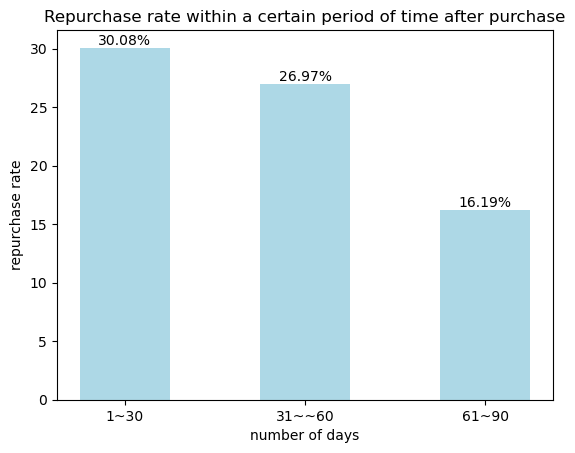

In [143]:
q = []
month_day = [30,  60, 90]

# 새로운 코드 추가
tranfinal_cus_2 = tranfinal_cus[tranfinal_cus.created_at.notnull()]
tranfinal_cus_2['created_at'] = pd.to_datetime(tranfinal_cus_2['created_at'])
tranfinal_cus_2['created_at_3'] = tranfinal_cus_2['created_at'].dt.strftime('%Y-%m-%d')
tranfinal_cus_22 = tranfinal_cus_2[(tranfinal_cus_2.created_at_3 >= '2020-08-01') & (tranfinal_cus.payment_status == 'Success')]

customer_purchase = tranfinal_cus_22.sort_values(by=['customer_id', 'created_at'])
customer_purchase['diff'] = customer_purchase.groupby('customer_id')['created_at'].diff()
customer_purchase.dropna(subset=['diff'], inplace=True)

def Repurchase_rate(first, day):
    repurchases_within_period = customer_purchase[(customer_purchase['diff'] > pd.Timedelta(days=first)) & (customer_purchase['diff'] <= pd.Timedelta(days=day))]
    repurchase_count = len(repurchases_within_period['customer_id'].unique())
    total_customers = len(customer_purchase['customer_id'].unique())
    repurchase_rate = repurchase_count / total_customers
    return repurchase_rate

print(f"(최근 2년) 구매 후 30일 이내 재구매율: {Repurchase_rate(0, 30):.1%}")
q.append(round(Repurchase_rate(0, 30), 4)*100)
print(f"(최근 2년) 구매 후 30일 이내 재구매율: {Repurchase_rate(31, 60):.1%}")
q.append(round(Repurchase_rate(31, 60), 4)*100)
print(f"(최근 2년) 구매 후 90일 이내 재구매율: {Repurchase_rate(61, 90):.1%}")
q.append(round(Repurchase_rate(61, 90), 4)*100)

plt.bar(month_day, q, lw=3, color='lightblue', width=15)
plt.xlabel('number of days')
plt.ylabel('repurchase rate')
plt.xticks(month_day, ['0~30', '31~~60', '61~90'], ha='center')
plt.title('Repurchase rate within a certain period of time after purchase')
for i, j in zip(month_day, q):
    plt.text(i, j, str(round(j,2))+'%', ha='center', va='bottom')

(최근 2년) 구매 후 30일 이내 재구매율: 14.24%
(최근 2년) 구매 후 30일 이내 재구매율: 30.08%
(최근 2년) 구매 후 30일 이내 재구매율: 41.58%
(최근 2년) 구매 후 60일 이내 재구매율: 50.82%
(최근 2년) 구매 후 90일 이내 재구매율: 57.80%


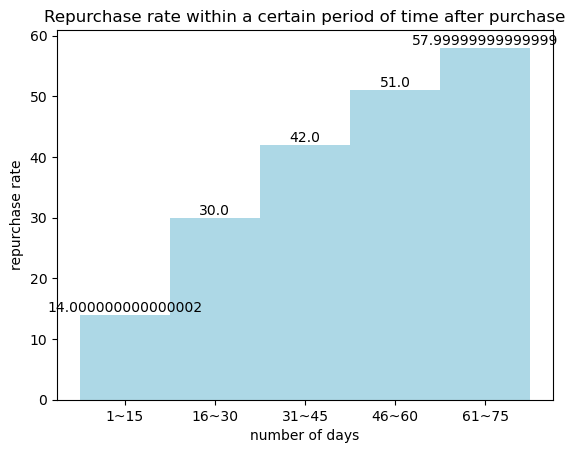

In [143]:
q=[]
month_day=[30,60,90]
# 새로구한것. 
tranfinal_cus_2 = tranfinal_cus[tranfinal_cus.created_at.notnull()]  # 구매를 안한 사람은 제외
tranfinal_cus_2['created_at'] = tranfinal_cus_2['created_at'].astype('datetime64')
tranfinal_cus_2['created_at_3'] = tranfinal_cus_2['created_at'].dt.strftime('%Y-%m-%d') # 날짜 형식 변형.
tranfinal_cus_22 = tranfinal_cus_2[(tranfinal_cus_2.created_at_3 >= '2020-08-01') & (tranfinal_cus.payment_status=='Success')]  # 최근 2년치만

# 고객별로 연이은 두 구매 사이의 시간 간격 계산
customer_purchase = tranfinal_cus_22.sort_values(by=['customer_id', 'created_at'])
customer_purchase['diff'] = customer_purchase.groupby('customer_id')['created_at'].diff()
customer_purchase.drop(index = customer_purchase[customer_purchase['diff'].isnull()].index, inplace=True)

def Repurchase_rate(first, day):
    # 지정된 기간 내 재구매 필터링
    repurchases_within_period = customer_purchase[(customer_purchase['diff'] <= pd.Timedelta(days=day))]
    # 지정된 기간 내 재구매한 고객 수 카운트
    repurchase_count = len(repurchases_within_period['customer_id'].unique())
    # 전체 고객 수 카운트
    total_customers = len(customer_purchase['customer_id'].unique())
    # 재구매율 계산
    repurchase_rate = repurchase_count / total_customers
    return repurchase_rate


print(f"(최근 2년) 구매 후 30일 이내 재구매율: {Repurchase_rate(15,30):.2%}")
a=round(Repurchase_rate(0,30),2)*100
q.append(a)
print(f"(최근 2년) 구매 후 60일 이내 재구매율: {Repurchase_rate(30,60):.2%}")
b=round(Repurchase_rate(30,60),2)*100
q.append(b)
print(f"(최근 2년) 구매 후 90일 이내 재구매율: {Repurchase_rate(60,90):.2%}")
c=round(Repurchase_rate(60,90),2)*100
q.append(c)

plt.bar(month_day, q, lw=3, color='lightblue', width=15)
plt.xlabel('number of days')
plt.ylabel('repurchase rate')
plt.xticks(month_day, ['30', '31~60', '61~90'], ha='center')
plt.title('Repurchase rate within a certain period of time after purchase')
for i, j in zip(month_day, q):
    plt.text(i, j, str(j), ha='center', va='bottom')

#### 재구매기간에 따른 고객 그룹화 분석

In [168]:
customer_purchase['diff_nums'] = customer_purchase['diff'].dt.days

In [169]:
customer_purchase.diff_nums.nunique()

425

In [170]:
customer_purchase['diff_nums'].describe()

count   465462.00
mean        33.31
std         42.40
min          0.00
25%         10.00
50%         19.00
75%         38.00
max        532.00
Name: diff_nums, dtype: float64

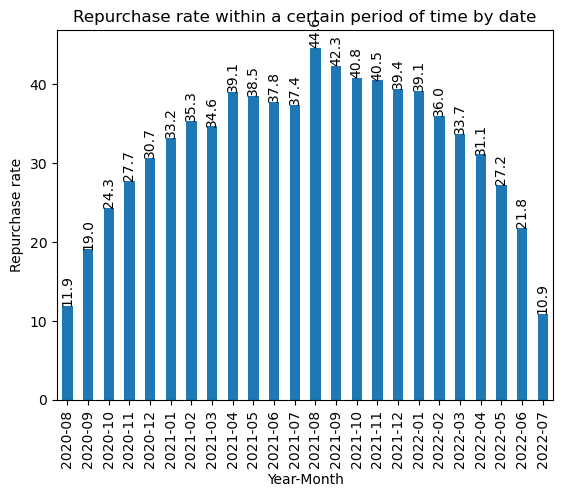

In [76]:
a = customer_purchase.groupby('created_at_2')['diff_nums'].mean()
a.plot.bar()
plt.xlabel('Year-Month')
plt.ylabel('Repurchase rate')
plt.title('Repurchase rate within a certain period of time by date')

for i, j in enumerate(a):
    plt.text(i, j, str(round(j, 1)), ha='center', va='bottom',rotation = 90)

plt.xticks(range(len(a.index)), a.index, rotation='vertical');

In [54]:
# 고객별 누적금액
age_sum = tranfinal_cus[(tranfinal_cus.created_at.notnull())&(tranfinal_cus.payment_status=='Success')].groupby(['customer_id','age2'])['total_amount'].sum().reset_index()

age_sum.groupby('age2')['total_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
age2,,,,,,,,
0,28.00,9410676.11,14048180.11,356685.00,1249511.00,4005532.00,8104470.25,54076391.00
10,7405.00,9306058.43,16830651.68,29809.00,759640.00,3041786.00,10455532.00,297669495.00
20,26001.00,8951030.49,16329754.83,27450.00,784840.00,3032715.00,9773089.00,320061849.00
30,14135.00,8767265.23,15393261.25,34118.00,759819.00,2958344.00,9733054.50,239123671.00
40,2438.00,8656020.19,15131869.33,66163.00,764346.50,2956566.00,9354864.00,203758664.00
50,219.00,9057051.27,16179993.54,73509.00,791068.50,2578946.00,9997121.50,137348207.00
60,16.00,4654583.94,8141236.34,366883.00,758930.25,2097205.00,4180098.50,33377555.00


<AxesSubplot:xlabel='age2'>

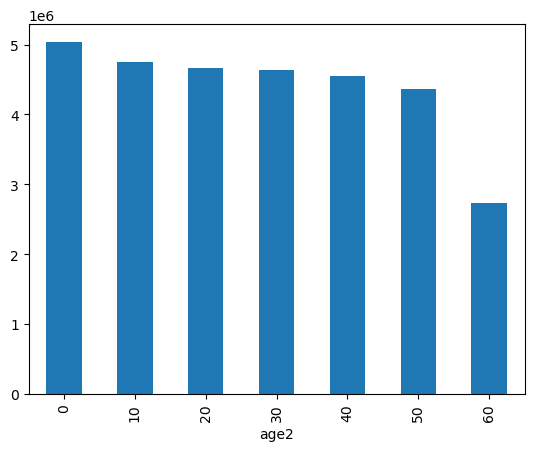

In [51]:
def remove_outliers(data, column):
    # 1사분위수 (Q1) 계산
    q1 = np.percentile(data[column], 25)
    # 3사분위수 (Q3) 계산
    q3 = np.percentile(data[column], 75)
    # IQR 계산
    iqr = q3 - q1
    # 이상치로 간주되는 범위 계산
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # 이상치를 제외한 데이터 필터링
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    return filtered_data

filtered_data = remove_outliers(age_sum, 'total_amount')
age_group_mean_purchase = filtered_data.groupby('age2')['total_amount'].mean()

age_group_mean_purchase.plot.bar()

In [69]:
tmp = tranfinal_cus[tranfinal_cus['payment_status']=='Success'].groupby('customer_id')['total_amount'].sum().reset_index()
tmp['total_amount'].describe()

count       50242.00
mean      8936691.30
std      16087604.88
min         27450.00
25%        773443.50
50%       3010699.00
75%       9832860.75
max     320061849.00
Name: total_amount, dtype: float64

In [70]:
tranfinal_cus_1 = tranfinal_cus[tranfinal_cus.created_at.notnull()].sort_values(['first_join_date','created_at'])
tranfinal_cus_1 = tranfinal_cus_1.groupby('customer_id').agg({
    'first_join_date': 'first',
    'created_at': 'first',
    'promo_yesno': [('yes', lambda x: (x == 'o').sum()),
                    ('no', lambda x: (x == 'x').sum()),
                    'first'],
    'quantity': 'sum',
    'age2':'first',
    'gender':'first',
    '가입 후 첫구매까지의 기간': 'first',
    'payment_status': [('payment_status_success', lambda x: (x == 'Success').sum()),
                       ('payment_status_fail', lambda x: (x == 'Failed').sum()),
                       'first']
}).reset_index()
tranfinal_cus_1.columns = [f'{x[0]}_{x[1]}' if x[1] != '' else x[0] for x in tranfinal_cus_1.columns]

In [137]:
tranfinal_cus_1.head()

,customer_id,first_join_date_first,created_at_first,promo_yesno_yes,promo_yesno_no,promo_yesno_first,quantity_sum,age2_first,gender_first,가입 후 첫구매까지의 기간_first,payment_status_payment_status_success,payment_status_payment_status_fail,payment_status_first
0,3,2018-08-25,2018-08-25 18:54:03,27,24,o,88.00,30,M,0.00,49,2,Success
1,8,2021-02-13,2021-02-13 09:47:39,1,6,o,19.00,20,F,0.00,7,0,Success
2,9,2021-06-26,2021-06-27 01:51:48,0,6,x,10.00,10,F,1.00,6,0,Success
3,11,2022-03-06,2022-03-07 14:29:13,1,0,o,1.00,20,M,1.00,1,0,Success
4,15,2019-09-28,2019-09-30 04:47:36,4,1,x,9.00,40,F,2.00,5,0,Success


In [71]:
tmp_tran = pd.merge(tranfinal_cus_1,tmp, on='customer_id',how='left')
tmp_tran.shape  # (50705, 12)
tmp_tran.head()

,customer_id,first_join_date_first,created_at_first,promo_yesno_yes,promo_yesno_no,promo_yesno_first,quantity_sum,age2_first,gender_first,가입 후 첫구매까지의 기간_first,payment_status_payment_status_success,payment_status_payment_status_fail,payment_status_first,total_amount
0,3,2018-08-25,2018-08-25 18:54:03,27,24,o,88.00,30,M,0.00,49,2,Success,20891374.00
1,8,2021-02-13,2021-02-13 09:47:39,1,6,o,19.00,20,F,0.00,7,0,Success,3898561.00
2,9,2021-06-26,2021-06-27 01:51:48,0,6,x,10.00,10,F,1.00,6,0,Success,2638665.00
3,11,2022-03-06,2022-03-07 14:29:13,1,0,o,1.00,20,M,1.00,1,0,Success,197533.00
4,15,2019-09-28,2019-09-30 04:47:36,4,1,x,9.00,40,F,2.00,5,0,Success,2134870.00


In [74]:
tmp_tran['group'] = tmp_tran['total_amount'].apply(lambda x: 0 if pd.isnull(x) else (1 if x<=773443 else(2 if x<=3010699 else 3 if x<=9832860 else (4 if x<=320061849 else 5))) )

In [75]:
# 누적금액으로 나눈 그룹
tmp_tran.groupby('group')['payment_status_first'].count()

group
0      463
1    12561
2    12560
3    12560
4    12561
Name: payment_status_first, dtype: int64

In [76]:
tmp_tran.groupby('group')['promo_yesno_yes'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
0,463.00,0.37,0.50,0.00,0.00,0.00,1.00,2.00
1,12561.00,0.52,0.66,0.00,0.00,0.00,1.00,5.00
2,12560.00,1.46,1.39,0.00,0.00,1.00,2.00,10.00
3,12560.00,3.93,3.04,0.00,2.00,3.00,6.00,25.00
4,12561.00,20.07,20.43,0.00,8.00,14.00,25.00,348.00


In [77]:
tmp_tran['count by group'] = tmp_tran['payment_status_payment_status_success'].apply(lambda x: 0 if x==0 else (1 if x==1 else(2 if x<=6 else 3 if x<=17 else (4 if x<=550 else 5))) )

In [78]:
# 구매횟수로 나눈 그룹
tmp_tran.groupby('count by group')['promo_yesno_yes'].describe()

,count,mean,std,min,25%,50%,75%,max
count by group,,,,,,,,
0,463.00,0.37,0.50,0.00,0.00,0.00,1.00,2.00
1,10263.00,0.37,0.50,0.00,0.00,0.00,1.00,4.00
2,16379.00,1.29,1.16,0.00,0.00,1.00,2.00,8.00
3,11060.00,4.10,2.54,0.00,2.00,4.00,6.00,19.00
4,12540.00,20.42,20.22,0.00,9.00,14.00,25.00,348.00


In [79]:
# 구매횟수로 나눈 그룹
tmp_tran.groupby('count by group')['promo_yesno_yes'].median()

count by group
0    0.00
1    0.00
2    1.00
3    4.00
4   14.00
Name: promo_yesno_yes, dtype: float64

In [156]:
tranfinal_cus_2 = tranfinal_cus[tranfinal_cus.created_at.notnull()]  # 구매를 안한 사람은 제외
tranfinal_cus_2['created_at'] = tranfinal_cus_2['created_at'].astype('datetime64')
tranfinal_cus_2['created_at_3'] = tranfinal_cus_2['created_at'].dt.strftime('%Y-%m-%d') # 날짜 형식 변형.
tranfinal_cus_22 = tranfinal_cus_2[(tranfinal_cus.payment_status=='Success')]  # 최근 2년치만

# 고객별로 연이은 두 구매 사이의 시간 간격 계산
customer_purchase = tranfinal_cus_22.sort_values(by=['customer_id', 'created_at'])
customer_purchase['diff'] = customer_purchase.groupby('customer_id')['created_at'].diff()
customer_purchase.drop(index = customer_purchase[customer_purchase['diff'].isnull()].index, inplace=True)
customer_purchase['diff_nums'] = customer_purchase['diff'].dt.days

In [162]:
dif = customer_purchase.groupby('customer_id')['diff_nums'].mean().reset_index()
dif['diff_new'] = dif['diff_nums'].apply(lambda x: '30days' if x<=30 else ('60days' if x<=60 else('90days' if x<=90 else 'more than 90 days')))
dif.head()

KeyboardInterrupt: 

In [84]:
tmp2 = pd.merge(tmp_tran,dif[['customer_id','diff_new']],on=['customer_id'],how='left')

Text(0, 0.5, '')

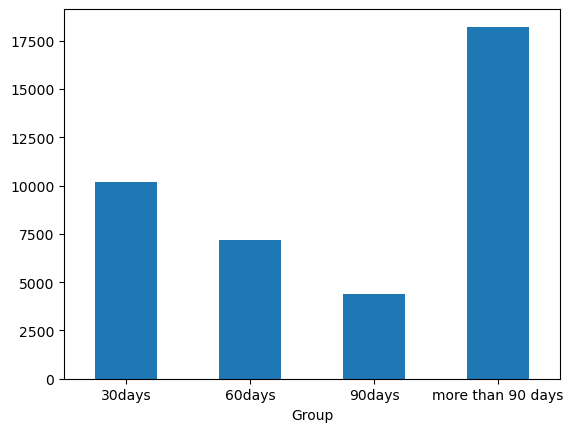

In [86]:
tmp2[~tmp2.diff_new.isnull()].groupby('diff_new')['customer_id'].count().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Group')
plt.ylabel('')

Text(0, 0.5, 'number of uses')

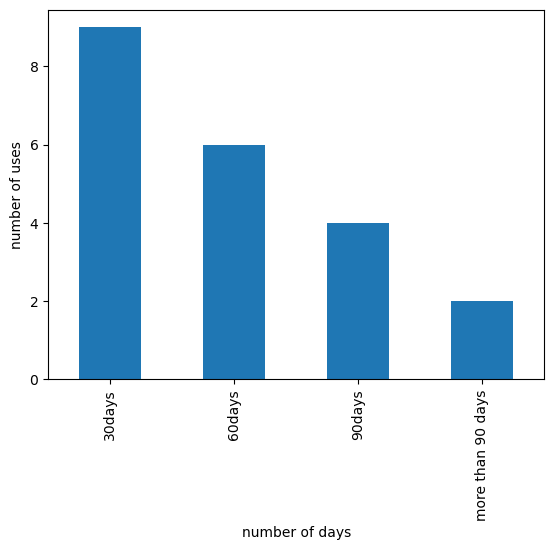

In [91]:
tmp2[~tmp2.diff_new.isnull()].groupby('diff_new')['promo_yesno_yes'].median().plot.bar()
plt.xlabel('number of days')
plt.ylabel('number of uses')

In [92]:
tmp2[~tmp2.diff_new.isnull()].groupby('diff_new')['promo_yesno_yes'].describe()

,count,mean,std,min,25%,50%,75%,max
diff_new,,,,,,,,
30days,10177.00,18.47,23.52,0.00,3.00,9.00,27.00,348.00
60days,7188.00,9.19,8.37,0.00,2.00,6.00,15.00,52.00
90days,4384.00,5.57,4.87,0.00,1.00,4.00,9.00,29.00
more than 90 days,18230.00,2.42,2.42,0.00,1.00,2.00,3.00,19.00


In [126]:
tmp2['count'] = tmp2['promo_yesno_yes'].apply(lambda x: 0 if x==0 else(1 if x<3 else (2 if x<10 else (3 if x<24 else 4))) )
tmp2[~tmp2.diff_new.isnull()].head()

,customer_id,first_join_date_first,created_at_first,promo_yesno_yes,promo_yesno_no,promo_yesno_first,quantity_sum,age2_first,gender_first,가입 후 첫구매까지의 기간_first,payment_status_payment_status_success,payment_status_payment_status_fail,payment_status_first,total_amount,group,count by group,diff_new,count
0,3,2018-08-25,2018-08-25 18:54:03,27,24,o,88.00,30,M,0.00,49,2,Success,20891374.00,4,4,30days,4
1,8,2021-02-13,2021-02-13 09:47:39,1,6,o,19.00,20,F,0.00,7,0,Success,3898561.00,3,3,90days,1
2,9,2021-06-26,2021-06-27 01:51:48,0,6,x,10.00,10,F,1.00,6,0,Success,2638665.00,2,2,90days,0
4,15,2019-09-28,2019-09-30 04:47:36,4,1,x,9.00,40,F,2.00,5,0,Success,2134870.00,2,2,more than 90 days,2
5,17,2018-11-24,2018-11-25 14:52:31,0,2,x,2.00,20,M,1.00,2,0,Success,456758.00,1,2,more than 90 days,0


In [127]:
tmp3 = tmp2[~tmp2.diff_new.isnull()].groupby(['count','diff_new']).count()['customer_id'].reset_index()
tmp3.groupby('count').sum()

,customer_id
count,
0,5009
1,12481
2,13294
3,5810
4,3385
